# Прогнозирование стоимости автомобилей на вторичном рынке

**Цель работы:** разработать модель предсказания стоимости автомобиля на вторичном рынке.

**Описание признаков таблиц**:

- `'year'` - год выпуска автомобиля;
- `'make'` - марка автомобиля;
- `'model'` - издание автомобиля определенной марки;
- `'trim'` - уровни отделки салона автомобиля (разные версии модели);
- `'body'` - тип кузова транспортного средства (относится к форме и модели конкретной марки автомобиля);
- `'transmission'` - механизм, который передает мощность от двигателя к колесам;
- `'vin'` - идентификационный номер транспортного средства;
- `'state'` - состояние, в котором автомобиль выставлен на аукцион;
- `'condition'` - состояние автомобилей на момент аукциона;
- `'odometer'` - расстояние, пройденное автомобилем с момента выпуска;
- `'color'` - цвет кузова автомобиля;
- `'interior'` - цвет салона автомобиля;
- `'seller'` - продавец автомобиля, автосалоны;
- `'sellingprice'` - цена, по которой автомобиль был продан на аукционе;
- `'saledate'` - дата продажи автомобиля.

**Этапы выполнения исследовательской паботы:**
- загрузка и ознакомление с данными;
- предварительная обработка;
- полноценный разведочный анализ;
- разработка новых синтетических признаков;
- проверка на мультиколлинеарность;
- отбор финального набора обучающих признаков;
- выбор и обучение моделей;
- итоговая оценка качества предсказания лучшей модели;
- анализ важности ее признаков.

## Загрузка и ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sklearn.preprocessing as pr_ng
import category_encoders as ce
import phik
import optuna
import warnings
import requests
import xgboost as xgb
import lightgbm as lgb
import scipy.stats as st
import association_metrics as am
import shap

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from optuna.samplers import TPESampler
from optuna import TrialPruned
from optuna.pruners import ThresholdPruner, SuccessiveHalvingPruner

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
shap.initjs()

RANDOM_STATE = 73

In [2]:
df_train_raw = pd.read_csv('Cars_train.csv')
df_test_raw = pd.read_csv('Cars_test.csv')

print('Вывод первых пяти строк для таблицы \'Cars_train.csv\'')
display(df_train_raw.head())
print('Вывод первых пяти строк для таблицы \'Cars_test.csv\'')
display(df_test_raw.head())

Вывод первых пяти строк для таблицы 'Cars_train.csv'


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


Вывод первых пяти строк для таблицы 'Cars_test.csv'


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [3]:
print('Вывод общей информации для таблицы \'Cars_train.csv\'', '\n')
df_train_raw.info()

Вывод общей информации для таблицы 'Cars_train.csv' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [4]:
passes_share = pd.DataFrame(df_train_raw.isna().sum(), columns=['passes'])
passes_share['share_%'] = (passes_share['passes'] * 100 / len(df_train_raw))
passes_share.style.background_gradient('coolwarm')

,passes,share_%
year,0,0.000000
make,8043,1.826975
model,8123,1.845147
trim,8337,1.893757
body,10393,2.360779
transmission,51461,11.689412
vin,0,0.000000
state,0,0.000000
condition,9405,2.136354
odometer,69,0.015673


Таблицы df_train и df_test включают 15/14 столбцов и 440236/110058 строк. Пропуски присутствуют в 9 столбцах из 15, приблизительно идентичые по относительному количеству в тестевой и обучающей выборках. Типы данных включают: 2 столбца `float64`, 1 столбец `int64`, 11 столбцов `object`.

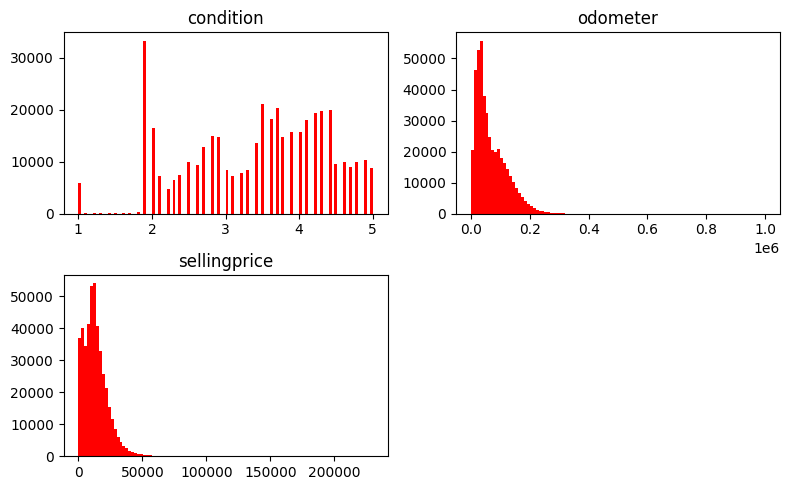

,count,mean,std,min,25%,50%,75%,max
condition,430831.0,3.43,0.95,1.0,2.7,3.6,4.2,5.0
odometer,440167.0,68344.42,53542.20,1.0,28258.0,52098.0,99272.0,999999.0
sellingprice,440236.0,13592.21,9751.48,1.0,6900.0,12100.0,18200.0,230000.0


In [5]:
# Озновные статистики числовых признаков
num_cols = ['condition','odometer','sellingprice']

df_train_raw[num_cols].hist(figsize=(8, 5), bins=100, grid=False, color='red');
plt.tight_layout()
plt.show()

df_train_raw[num_cols].describe().round(2).transpose()

Подозрения вызывают минимальное значение признака `sellingprice` и максимальные значения признака `odometer`.

In [6]:
# Основные статистики категориальных признаков
cat_cols = list(set(df_train_raw.columns) - set(num_cols))

df_train_raw[cat_cols].astype('object').describe(include = ['object']).transpose()

,count,unique,top,freq
state,440236,38,fl,65618
vin,440236,440236,2fmdk3jc4bba41556,1
year,440236,34,2012,80625
body,429843,85,Sedan,157639
saledate,440236,3597,Tue Feb 10 2015 01:30:00 GMT-0800 (PST),4209
trim,431899,1922,Base,43853
make,432193,92,Ford,73708
interior,439650,17,black,192442
transmission,388775,2,automatic,375061
model,432113,959,Altima,15454


Признак `vin` несёт в себе только уникальные значения, вероятно классификационной ценности он не несёт. Высоко кардинальные признаки `model`, `trim`, `seller` и `saledate` будут требовать дополнительной обработки.

In [7]:
print('Количество дубликатов:', df_train_raw.drop(['vin', 'seller', 'saledate'], axis=1).duplicated().sum())

Количество дубликатов: 0


Оставив только признаки собственных характеристик автомобилей, очевидно, что дубликаты отсутствуют. Основные статистики в целом подозрений не вызывают, признак `'vin'` имеет 100% уникальных значений, вероятно его классифицирующая сила будет ничтожна. Признак `'transmission'` имеет только 2 значения, есть смысл его сделать бинарным. У признака `'saledate'` есть смысл расмотреть отдельные временные категории продажи.

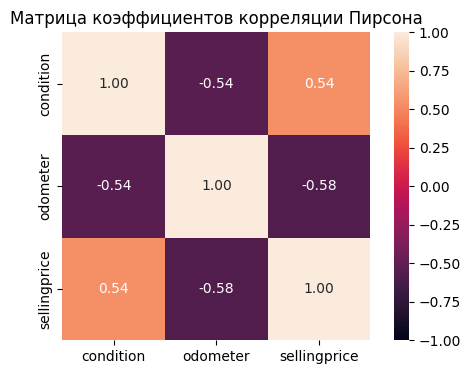

In [8]:
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_train_raw[num_cols].corr(), vmin=-1, vmax=1, square=True, annot=True, fmt='.2f');
plt.title('Матрица коэффициентов корреляции Пирсона')
plt.show()

In [9]:
CALCULATION_OF_PARAMETERS = False
if CALCULATION_OF_PARAMETERS:
    f, ax = plt.subplots(figsize=(10, 8))
    phik_matrix = df_train_raw.drop(['vin','saledate'], axis=1).phik_matrix(interval_cols=num_cols)
    sns.heatmap(phik_matrix, vmin=0, vmax=1, square=True, annot=True, fmt='.2f')
    plt.title('Матрица коэффициентов корреляции Фи (Phi) исходный данных')
    plt.show()

<image src="https://sun9-24.userapi.com/impg/-KF1hI6n2D-UlUMc3r-YezeEa2OG0ei_zcnUJw/7539GTkWY9I.jpg?size=835x756&quality=95&sign=cb171b19ad399c340f5a30cbd9fb60b3&type=album" alt="Матрица коэффициентов корреляции Фи (Phi) исходный данных"></img>

## Предварительная обработка данных

### Обработка пропусков

Выполним парсинг информации с сайта министерства транспорта США, используя наличие 'VIN' у записей, имеющих пропуски.

In [10]:
# Парсинг пропущеных значений тестевой и тренировочной выборок
CALCULATION_OF_PARAMETERS = False
if CALCULATION_OF_PARAMETERS:
    columns_with_null = ['make','model','trim','body','transmission', 'vin']
    column_mapping = {'Make': 'make', 'Model': 'model', 'Trim': 'trim', 'BodyClass': 'body', 'TransmissionStyle': 'transmission', 'VIN': 'vin'}
    line_with_null = df_train_raw[df_train_raw.isna().any(axis=1)].vin # Фильтруем строки с пропусками

    df_vin = pd.DataFrame(columns=columns_with_null)

    API_URL = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/'

    first = 0
    last = 50
    for i in range(int(np.ceil(line_with_null.shape[0]/50))):
        delim_vin_list = '; '.join([str(x) for x in list(line_with_null[first:last])]) # Слайдируем vin
        data_vin_request = requests.post(API_URL, data={'format': 'json', 'data': delim_vin_list}) # Формируем запрос
        data_vin = pd.DataFrame(data_vin_request.json()['Results'])
        data_vin = data_vin.rename(columns=column_mapping)
        data_vin = data_vin[columns_with_null]
        df_vin = pd.concat([df_vin, data_vin], axis=0, ignore_index=True)
        first += 50
        last += 50

    df_vin.to_csv('Cars_df_train_passes.csv', index=False)

else: # Заполняем пропущенные значения найденными данными
    df_train_passes = pd.read_csv('Cars_df_train_passes.csv')
    df_test_passes = pd.read_csv('Cars_df_test_passes.csv')

    for col in ['make','model','trim','body','transmission']:
        df_train_raw[col] = df_train_raw[col].fillna(df_train_raw['vin'].map(df_train_passes.set_index('vin')[col]))
        df_test_raw[col] = df_test_raw[col].fillna(df_test_raw['vin'].map(df_test_passes.set_index('vin')[col]))

Пропуски признаков `interior`, `color`, `make`, `model`, `trim` заполняем заглушкой unknown.
Признак `body` хорошо коррелирует с признаком `model`, в связи с чем по аналогии заполняем заглушкой unknown, остальные пропуски заполняем, используя CatBoostClassifier.
Пропуски признака `transmission` заполняем наиболее частым значением.
Пропуски признака `odometer` заполняем медианным значением, сгруппированным по годам производства автомобилей.
Признак `condition`, хорошо коррелирует с признаками `model`, `seller` и `year`, используя CatBoostRegressor выполним заполнение.

In [11]:
# Подчищае строчные данные
df_train_raw = df_train_raw.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
df_test_raw = df_test_raw.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

df_train_raw = df_train_raw.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
df_test_raw = df_test_raw.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

# Ставим заглушку
df_train_raw[['interior','color','make','model','trim','body']] = df_train_raw[['interior','color','make','model','trim','body']].fillna('unknown')
df_test_raw[['interior','color','make','model','trim','body']] = df_test_raw[['interior','color','make','model','trim','body']].fillna('unknown')

# Заполнение медианным значением
for pas in df_train_raw['year'].unique():
    df_train_raw.loc[(df_train_raw['year'] == pas)&(df_train_raw['odometer'].isna()), 'odometer'] = df_train_raw.loc[(df_train_raw['year'] == pas), 'odometer'].median()
for pas in df_test_raw['year'].unique():
    df_test_raw.loc[(df_test_raw['year'] == pas)&(df_test_raw['odometer'].isna()), 'odometer'] = df_test_raw.loc[(df_test_raw['year'] == pas), 'odometer'].median()

# Заполнение классификатором признака transmission на основе признаков 'make','model','trim','body'
cbc = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE, task_type='GPU', devices='0:1')
cbc.fit(df_train_raw[~df_train_raw.transmission.isna()][['make','model','trim','body']],
        df_train_raw[~df_train_raw.transmission.isna()]['transmission'].values,
        cat_features=['make','model','trim','body'])
df_train_raw.loc[df_train_raw.transmission.isna(),'transmission'] = cbc.predict(df_train_raw[df_train_raw.transmission.isna()][['make','model','trim','body']])
df_test_raw.loc[df_test_raw.transmission.isna(),'transmission'] = cbc.predict(df_test_raw[df_test_raw.transmission.isna()][['make','model','trim','body']])

# Заполнение регрессором признака condition на основе признаков model, seller, year
cbr_model = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE, task_type='GPU', devices='0:1')
cbr_model.fit(df_train_raw[~df_train_raw.condition.isna()][['model','seller','year']], 
              df_train_raw[~df_train_raw.condition.isna()]['condition'].values,
              cat_features=['model','seller'])
df_train_raw.loc[df_train_raw.condition.isna(),'condition'] = cbr_model.predict(df_train_raw[df_train_raw.condition.isna()][['model','seller','year']])
df_test_raw.loc[df_test_raw.condition.isna(),'condition'] = cbr_model.predict(df_test_raw[df_test_raw.condition.isna()][['model','seller','year']])

In [12]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

df_train_research = optimize_memory_usage(df_train_raw)
df_test_research = optimize_memory_usage(df_test_raw)

Размер использования памяти: до 50.38 Mb - после 42.82 Mb (15.0%)
Размер использования памяти: до 11.76 Mb - после 10.29 Mb (12.5%)


## Разведочный анализ данных

### Исследование признаков данных

In [13]:
def building_histogram_feature (df: pd.DataFrame, feature: str, bins: int, logy: bool) -> plt:
    '''
    The function implements the feature histogram, boxplot and describe
    df: pd.DataFrame - table with feature
    bins: int - number of histogram columns
    feature: str - considered feature
    logy: bool - logarithmic y-axis scale
    return plt - graph
    '''
    gridsize = (4, 1)
    _, axs = plt.subplots(nrows=2, ncols=1)
    axs[0] = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=3)
    axs[1] = plt.subplot2grid(gridsize, (3, 0))
    df.plot(y=feature, kind='hist', bins=bins, figsize=(11,5), ax=axs[0], legend=False, sharex=True, histtype='step', logy=logy);
    df.boxplot(column=feature, vert=False, ax=axs[1], grid=False);
    axs[0].set_title(f'Гистограмма и диаграмма размаха для признака \'{feature}\'')
    axs[1].set_xlabel(f'Значения признака \'{feature}\'')
    axs[0].set_ylabel('Частота значений признака \'{feature}\'')
    axs[1].set_ylim(0.87, 1.13)
    axs[0].set_xlim(df[feature].min() - 0.01 * df[feature].min(), df[feature].max() + 0.01 * df[feature].min())
    axs[1].set_xlim(df[feature].min() - 0.01 * df[feature].min(), df[feature].max() + 0.01 * df[feature].min())
    return plt.show()

def count_unique_discrepancies(df_1: pd.DataFrame, df_2: pd.DataFrame, feature: str) -> int:
    '''
    Calculates the number of non-matching unique features in two selections
    df_1: pd.DataFrame - first fetch
    df_2: pd.DataFrame - second fetch
    feature: str - considered feature
    return: int - number of non-matching unique objects
    '''
    set_first = set(df_1[feature])
    set_second = set(df_2[feature])
    return len(set_first.symmetric_difference(set_second))

def output_number_emissions(df: pd.DataFrame, feature: str) -> int:
    '''
    Output of the number of emissions
    df: pd.DataFrame - table with feature
    feature: str - considered feature
    return: int - number of outliers
    '''
    perc_max = (np.percentile(df[feature], 75) - np.percentile(df[feature], 25)) * 1.5 + np.percentile(df[feature], 75)
    perc_min = np.percentile(df[feature], 25) - (np.percentile(df[feature], 75) - np.percentile(df[feature], 25)) * 1.5
    return df[(df[feature] > perc_max)|(df[feature] < perc_min)][feature].count()

#### Год выпуска автомобиля `'year'`

In [14]:
bar_chart = go.Bar(
    x=df_train_research.year.value_counts().sort_index().index,
    y=df_train_research.year.value_counts().sort_index().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частоты продаваемых автомобилей за год',
    xaxis=dict(title='Год выпуска автомобиля'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Основная доля проданных автомобилей относится к 2011-2014 гг. С 1988 года происходил планомерный рост продаж, только в 2015 наблюдается резкий спад, что возможно связано с кризисом 2014 года.

In [15]:
print('Количество уникальных значений признаков:', df_train_research.year.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'year'))
print('Уникальные значения признака:', '\n', df_train_research.year.sort_values().unique())

Количество уникальных значений признаков: 34
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 3
Уникальные значения признака: 
 [1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015]


Очень малая доля продаж автомобилей до 1989 года производства, вероятно есть смысл обьединить их в одну категорию, для того, что бы моделе не пришлось предсказывать очень редкие события. Код будет оформлен в конце исследования.

#### Марка автомобиля `'make'`

In [16]:
bar_chart = go.Bar(
    x=df_train_research.make.value_counts().index,
    y=df_train_research.make.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частоты продаваемых марок автомобилей',
    xaxis=dict(title='Марка автомобиля'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Самой продаваемой маркой автомобиля является ford, так же хорошие продажи у chevrolet, nissan, toyota, dodge и honda.

In [17]:
print('Количество уникальных значений признаков:', df_train_research.make.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'make'))
print('Уникальные значения признака:', '\n', df_train_research.make.sort_values().unique())

Количество уникальных значений признаков: 64


Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 12
Уникальные значения признака: 
 ['acura' 'airstream' 'aston martin' 'audi' 'bentley' 'bmw' 'buick'
 'cadillac' 'chevrolet' 'chrysler' 'daewoo' 'dodge' 'dodge tk' 'dot'
 'ferrari' 'fiat' 'fisker' 'ford' 'ford truck' 'freightliner' 'geo' 'gmc'
 'gmc truck' 'honda' 'hummer' 'hyundai' 'infiniti' 'isuzu' 'jaguar' 'jeep'
 'kia' 'lamborghini' 'land rover' 'landrover' 'lexus' 'lincoln' 'maserati'
 'mazda' 'mazda tk' 'mercedes' 'mercedes-b' 'mercedes-benz' 'mercury'
 'mini' 'mitsubishi' 'nissan' 'oldsmobile' 'plymouth' 'pontiac' 'porsche'
 'ram' 'rolls-royce' 'saab' 'saturn' 'scion' 'smart' 'subaru' 'suzuki'
 'tesla' 'toyota' 'unknown' 'volkswagen' 'volvo' 'vw']


Разные марки автомобилей имеют вариацию в названиях в зависимости от даты производства и т.д. Выполним унификацию.

In [18]:
for df in [df_train_research, df_test_research]:
    df['make'] = df['make'].replace('dodge tk', 'dodge')
    df['make'] = df['make'].replace('ford truck', 'ford')
    df['make'] = df['make'].replace('gmc truck', 'gmc')
    df['make'] = df['make'].replace(['mercedes-b','mercedes-benz'], 'mercedes')
    df['make'] = df['make'].replace('mazda tk', 'mazda')
    df['make'] = df['make'].replace('landrover', 'land rover')
    df['make'] = df['make'].replace('vw', 'volkswagen')

#### Издание автомобиля определенной марки `'model'`

In [19]:
bar_chart = go.Bar(
    x=df_train_research.model.value_counts().index,
    y=df_train_research.model.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частот продаваемых моделей автомобилей',
    xaxis=dict(title='Модели автомобилей'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Наиболее продаваемые марки автомобилей, с продажами свыше 10К: altima, f-150, fusion, camry, которые занимают 10,7% рынка. Марки с продажами от 10К до 5К занимают 28,8%, хотя эта группа составляет уже 16 марок автомобилей.

In [20]:
print('Количество уникальных значений признаков:', df_train_research.model.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'model'))
print('Уникальные значения признака:', '\n', df_train_research.model.sort_values().unique())

Количество уникальных значений признаков: 881
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 125
Уникальные значения признака: 
 ['1 series' '1500' '190-class' '2 series' '200' '200sx' '2500' '3'
 '3 series' '3 series gran turismo' '300' '300-class' '3000gt' '300c'
 '300e' '300m' '300zx' '320i' '323i' '328i' '335i' '3500' '350z'
 '360 modena' '370z' '380' '4 series' '4 series gran coupe' '400-class'
 '420' '420-class' '420sel' '428i' '42c' '458 italia' '4runner' '5 series'
 '5 series gran turismo' '500' '500-class' '500e' '500l' '535i' '560' '6'
 '6 series' '6 series gran coupe' '626' '650i / alpina b6' '7' '7 series'
 '750i' '750i / alpina b7' '750li' '750li / alpina b7' '750lxi'
 '750lxi / alpina b7' '750xi' '750xi / alpina b7' '8 series' '850' '9-2x'
 '9-3' '9-5' '9-7x' '911' '940' '944' '960' 'a3' 'a4' 'a5' 'a6' 'a7' 'a8'
 'acadia' 'accent' 'accord' 'accord crosstour' 'accord hybrid'
 'activehybrid 5' 'activehybrid 7' 'activehybrid x6' 'aerio' 'alero'

In [21]:
dubl_values = []
for make_value in df_train_research['make'].unique():
    make_models = df_train_research[df_train_research['make'] == make_value]['model'].unique()
    other_models = df_train_research[df_train_research['make'] != make_value]['model'].unique()
    dubl_values.append(np.isin(make_models, other_models).sum())

print('Число кросплатформенных моделей от разных марок производителей', sum(dubl_values))

Число кросплатформенных моделей от разных марок производителей 59


Одна и таже модель автомобиля может продаваться под разными марками (42 штуки), что не позволяет избавится от признака `make`, как менее информативного, поскольку он несёт информацию о кроссплатформенных моделях для ML.

#### Уровни отделки салона автомобиля (разные версии модели) `'trim'`

In [22]:
print('Количество уникальных значений признаков:', df_train_research.trim.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'trim'))
print('Уникальные значения признака:', '\n', df_train_research.trim.sort_values().unique())

Количество уникальных значений признаков: 1951
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 544
Уникальные значения признака: 
 ['!' '& coun fwd' '& coun fwd limited' ... 'zx5 se' 'zx5 ses' 'zxw ses']


In [23]:
dubl_values = []
for make_value in df_train_research['model'].unique():
    make_models = df_train_research[df_train_research['model'] == make_value]['trim'].unique()
    other_models = df_train_research[df_train_research['model'] != make_value]['trim'].unique()
    dubl_values.append(np.isin(make_models, other_models).sum())

print('Число пересикающихся типов отделки салонов различных моделей автомобилей', sum(dubl_values))

Число пересикающихся типов отделки салонов различных моделей автомобилей 2805


Различные уровни отделки салона автомобиля могут быть у одной и той же модели (2543 пересечений), что не позволяет избавится от признака `model`, как менее информативного.

#### Тип кузова транспортного средства `'body'`

In [24]:
bar_chart = go.Bar(
    x=df_train_research.body.value_counts().index,
    y=df_train_research.body.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частот продаваемых типов кузовов автомобилей',
    xaxis=dict(title='Тип кузова автомобиля'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Наиболее часто продаваемые типы кузовов являются sedan и suv и составляют 69%, ещё 17 последующих типов составляет 30% продаж. При этом 58% типов кузовав составляет менее 1% продаж.

In [25]:
print('Количество уникальных значений признаков:', df_train_research.body.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'body'))
print('Уникальные значения признака:', '\n', df_train_research.body.sort_values().unique())

Количество уникальных значений признаков:

 61
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 7
Уникальные значения признака: 
 ['access cab' 'beetle convertible' 'cab plus' 'cab plus 4' 'cargo van'
 'club cab' 'convertible' 'convertible/cabriolet' 'coupe' 'crew cab'
 'crewmax cab' 'cts coupe' 'cts wagon' 'cts-v coupe' 'cts-v wagon'
 'double cab' 'e-series van' 'elantra coupe' 'extended cab'
 'g convertible' 'g coupe' 'g sedan' 'g37 convertible' 'g37 coupe'
 'genesis coupe' 'granturismo convertible' 'hatchback'
 'hatchback/liftback/notchback' 'incomplete'
 'incomplete - chassis cab (number of cab unknown)'
 'incomplete - chassis cab (single cab)' 'incomplete - commercial chassis'
 'incomplete - cutaway' 'king cab' 'koup' 'limousine' 'mega cab' 'minivan'
 'pickup' 'promaster cargo van' 'q60 convertible' 'q60 coupe' 'quad cab'
 'ram van' 'regular cab' 'regular-cab' 'roadster' 'sedan' 'sedan/saloon'
 'sport utility truck (sut)'
 'sport utility vehicle (suv)/multi-purpose vehicle (mpv)' 'supercab'
 's

#### Механизм, который передает мощность от двигателя к колесам `'transmission'`

In [26]:
print('Количество уникальных значений признаков:', df_train_research.transmission.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'transmission'))
print('Уникальные значения признака:', '\n', df_train_research.transmission.sort_values().unique())

Количество уникальных значений признаков: 5
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 0
Уникальные значения признака: 
 ['automated manual transmission (amt)' 'automatic'
 'continuously variable transmission (cvt)' 'manual' 'manual/standard']


In [27]:
df_train_research.transmission.value_counts()

transmission
automatic                                   425909
manual                                       13839
continuously variable transmission (cvt)       305
manual/standard                                173
automated manual transmission (amt)             10
Name: count, dtype: int64

Наиболее часто встречающийся тип трансмиссии в продаваемых машинах это автоматика и составляет 97%.

#### Идентификационный номер транспортного средства `'vin'`

In [28]:
print('Количество уникальных значений признаков:', df_train_research.vin.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'vin'))
print('Уникальные значения признака:', '\n', df_train_research.vin.sort_values().unique())

Количество уникальных значений признаков: 440236
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 550294
Уникальные значения признака: 
 ['137fa90362e197965' '137za84341e193591' '137za8435ye187468' ...
 'zhwgu22t47la04254' 'zhwgu22t47la04447' 'zhwgu22t97la05738']


In [29]:
df_train_research.vin.nunique()

440236

Количество уникальных значений признака на 100% совпадает с размером DF, что свидетельствует об отсутствии классификационной значимости.

#### Cостояние, в котором автомобиль выставлен на аукцион `'state'`

In [30]:
bar_chart = go.Bar(
    x=df_train_research.state.value_counts().index,
    y=df_train_research.state.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма состояний продоваемых автомобилей',
    xaxis=dict(title='Cостояние, в котором автомобиль выставлен на аукцион'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Половина продаваемых автомобилей относится к состояниям: fl, ca, pa, tx и ga.

In [31]:
print('Количество уникальных значений признаков:', df_train_research.state.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'state'))
print('Уникальные значения признака:', '\n', df_train_research.state.sort_values().unique())

Количество уникальных значений признаков: 38
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 0
Уникальные значения признака: 
 ['ab' 'al' 'az' 'ca' 'co' 'fl' 'ga' 'hi' 'il' 'in' 'la' 'ma' 'md' 'mi'
 'mn' 'mo' 'ms' 'nc' 'ne' 'nj' 'nm' 'ns' 'nv' 'ny' 'oh' 'ok' 'on' 'or'
 'pa' 'pr' 'qc' 'sc' 'tn' 'tx' 'ut' 'va' 'wa' 'wi']


#### Состояние автомобилей на момент аукциона `'condition'`

In [32]:
print('Количество уникальных значений признаков:', df_train_research.condition.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'condition'))
print('Уникальные значения признака:', '\n', df_train_research.condition.sort_values().unique())

Количество уникальных значений признаков: 7911
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 9167
Уникальные значения признака: 
 [1.        1.0446773 1.1       ... 4.8       4.9       5.       ]


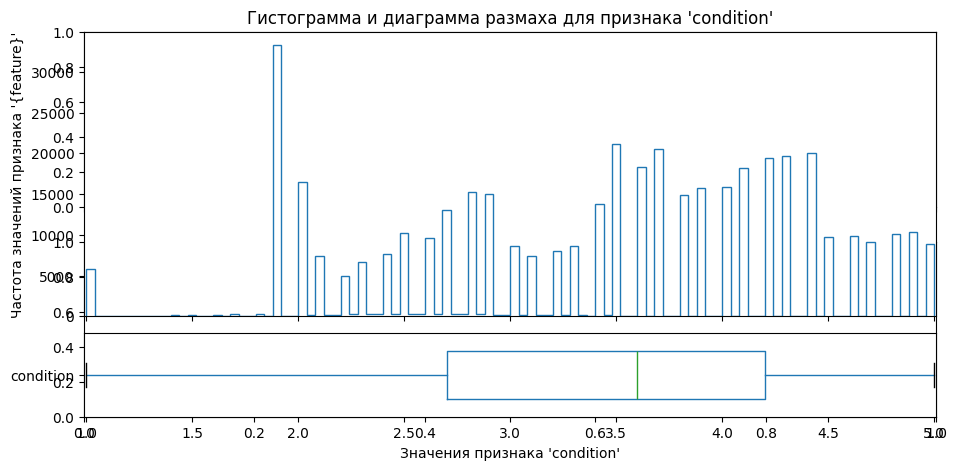

,condition_x,condition_y
count,440236.0,110058.0
mean,3.4,3.4
std,0.9,0.9
min,1.0,1.0
25%,2.7,2.7
50%,3.6,3.6
75%,4.2,4.2
max,5.0,5.0


In [33]:
building_histogram_feature (df_train_research, 'condition', 100, False)

pd.merge(df_train_research.condition.describe().round(1), 
         df_test_research.condition.describe().round(1), 
         left_index=True, right_index=True, how='outer')

Распределение значений признака имеет точно очерченные границы (от 1 до 5), поскольку он является мерой оценки. В целом можно отметить что "центр массы распределения" смещён правее к 3,6-3,4. Однако явно виден провал частот от 1 до 1,9 с сильным нетипичным пиком на 1,9, складывается ощущение, что этот пик и вобрал на себя весь провал частот распределения до его.

#### Цвет кузова автомобиля `'color'`

In [34]:
bar_chart = go.Bar(
    x=df_train_research.color.value_counts().index,
    y=df_train_research.color.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частоты продаваемых расцветок автомобилей',
    xaxis=dict(title='Расцветка автомобиля'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Наиболее часто продаваемые расцветки black и white (39%), silver и gray (30%), blue и red (17%). Явно наблюдается некоторое подобие попарной корреляций цветов автомобиля, перечисленных ранее. Остальные 68% расцветок занимают менее 14% продаж.

В признаке `color`, пропуски были заполнены заглушкой unknown, однако в перечне значений есть дефис, который так же явно обозначает отсутствие цвета. Выполним приведение к единому образцу.

In [35]:
df_train_research['color'] = df_train_research['color'].replace('—', 'unknown')
df_test_research['color'] = df_test_research['color'].replace('—', 'unknown')

print('Количество уникальных значений признаков:', df_train_research.color.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'color'))
print('Уникальные значения признака:', '\n', df_train_research.color.sort_values().unique())

Количество уникальных значений признаков: 20
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 0
Уникальные значения признака: 
 ['beige' 'black' 'blue' 'brown' 'burgundy' 'charcoal' 'gold' 'gray'
 'green' 'lime' 'off-white' 'orange' 'pink' 'purple' 'red' 'silver'
 'turquoise' 'unknown' 'white' 'yellow']


#### Цвет салона автомобиля `'interior'`

In [36]:
bar_chart = go.Bar(
    x=df_train_research.interior.value_counts().index,
    y=df_train_research.interior.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частоты продаваемых расцветок салонов автомобилей',
    xaxis=dict(title='Расцветка салона автомобиля'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

Наиболее часто продаваемые расцветки салона black и gray (76%), beige и tan (19%). Остальные 77% расцветок занимают менее 5% продаж.

В признаке `interior`, пропуски были заполнены заглушкой unknown, однако в перечне значений есть дефис, который так же явно обозначает отсутствие цвета. Выполним приведение к единому образцу.

In [37]:
df_train_research['interior'] = df_train_research['interior'].replace('—', 'unknown')
df_test_research['interior'] = df_test_research['interior'].replace('—', 'unknown')

print('Количество уникальных значений признаков:', df_train_research.interior.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'interior'))
print('Уникальные значения признака:', '\n', df_train_research.interior.sort_values().unique())

Количество уникальных значений признаков: 17
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 0
Уникальные значения признака: 
 ['beige' 'black' 'blue' 'brown' 'burgundy' 'gold' 'gray' 'green'
 'off-white' 'orange' 'purple' 'red' 'silver' 'tan' 'unknown' 'white'
 'yellow']


#### Продавец автомобиля, автосалоны `'seller'`

In [38]:
print('Количество уникальных значений признаков:', df_train_research.seller.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'seller'))
print('Уникальные значения признака:', '\n', df_train_research.seller.sort_values().unique())

Количество уникальных значений признаков: 13025
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 7538
Уникальные значения признака: 
 ['1 cochran of monroeville' '1 for all auto sales' '1360250 alberta ltd.'
 ... 'zonemotors.com inc' 'zoom auto' 'zygi auto corp']


Признак `seller` имеет большое количество уникальных значений и огромное количество несовпадений со значениями в тестевой выборки. Попробуем уменьшить кардинальность признака, сгрупировав редкие события с числом продаж менее 3 (выбиралось исходя из влияния на метрику MAPE) в признак rare seller, тем самым сокращая пространство значений признака с 13025 до 5572 (57,2%) и снижаем количество несовпадений с типами кузовов автомобилей тестовой выборки с 7538 до 1843 (75,6%).

#### Цена, по которой автомобиль был продан на аукционе `'sellingprice'`

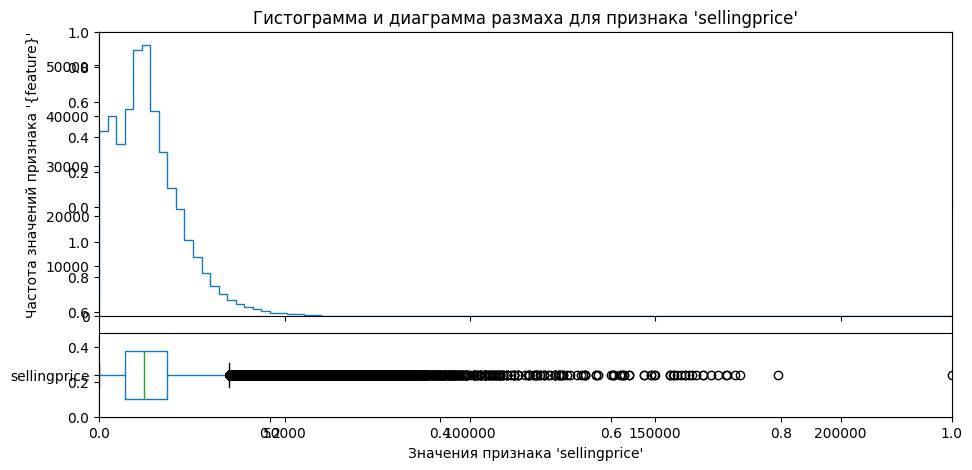

Количество выбросов в признаке sellingprice: 12836


count    440236.0
mean      13592.2
std        9751.5
min           1.0
25%        6900.0
50%       12100.0
75%       18200.0
max      230000.0
Name: sellingprice, dtype: float64

In [39]:
building_histogram_feature (df_train_research, 'sellingprice', 100, False)
print('Количество выбросов в признаке sellingprice:', output_number_emissions(df_train_research, 'sellingprice'))

df_train_research.sellingprice.describe().round(1)

In [40]:
df_train_research = df_train_research.loc[df_train_research['sellingprice'] > 50]

Высокий диапазон разброса значений цены продажи (от 100 до 230К) характеризует большая дисперсия 9,7К. Среднее значение цены (13,6К) заметно превышает медианного значение (12,1К) из-за наличия большого количества выбросов в данных (13,8К). Избавляться от выбросов не разумно, поскольку они вероятно представляют отдельный сегмент рынка продажи автомобилей.

#### Дата продажи автомобиля `'saledate'` (возраст автомобиля `'car_age'`)

Заменим признак даты продажи на возраст автомобиля в годах. А так же создадим признаки месяц продажи и неделя продажи.

In [41]:
df_train_research['car_age'] = pd.to_datetime(df_train_research['saledate'].str[:-15].copy())
df_test_research['car_age'] = pd.to_datetime(df_test_research['saledate'].str[:-15].copy())

df_train_research.loc[df_train_research['saledate'].str.contains('(PDT)'),'car_age'] = df_train_research.loc[df_train_research['saledate'].str.contains('(PDT)'),'car_age'] - pd.Timedelta(hours=7)
df_train_research.loc[df_train_research['saledate'].str.contains('(PST)'),'car_age'] = df_train_research.loc[df_train_research['saledate'].str.contains('(PST)'),'car_age'] - pd.Timedelta(hours=8)
df_test_research.loc[df_test_research['saledate'].str.contains('(PDT)'),'car_age'] = df_test_research.loc[df_test_research['saledate'].str.contains('(PDT)'),'car_age'] - pd.Timedelta(hours=7)
df_test_research.loc[df_test_research['saledate'].str.contains('(PST)'),'car_age'] = df_test_research.loc[df_test_research['saledate'].str.contains('(PST)'),'car_age'] - pd.Timedelta(hours=8)

df_train_research['car_age'] = df_train_research['car_age'].dt.year.astype('int16') - df_train_research['year']
df_test_research['car_age'] = df_test_research['car_age'].dt.year.astype('int16') - df_test_research['year']

df_train_research['saledate'] = pd.to_datetime(df_train_research['saledate'].str[:-15])
df_test_research['saledate'] = pd.to_datetime(df_test_research['saledate'].str[:-15])

df_train_research['sale_month'] = pd.DatetimeIndex(df_train_research['saledate']).month
df_test_research['sale_month'] = pd.DatetimeIndex(df_test_research['saledate']).month

df_train_research['sale_dayofweek'] = pd.DatetimeIndex(df_train_research['saledate']).dayofweek
df_test_research['sale_dayofweek'] = pd.DatetimeIndex(df_test_research['saledate']).dayofweek

df_train_research.drop('saledate', axis=1, inplace=True)
df_test_research.drop('saledate', axis=1, inplace=True)

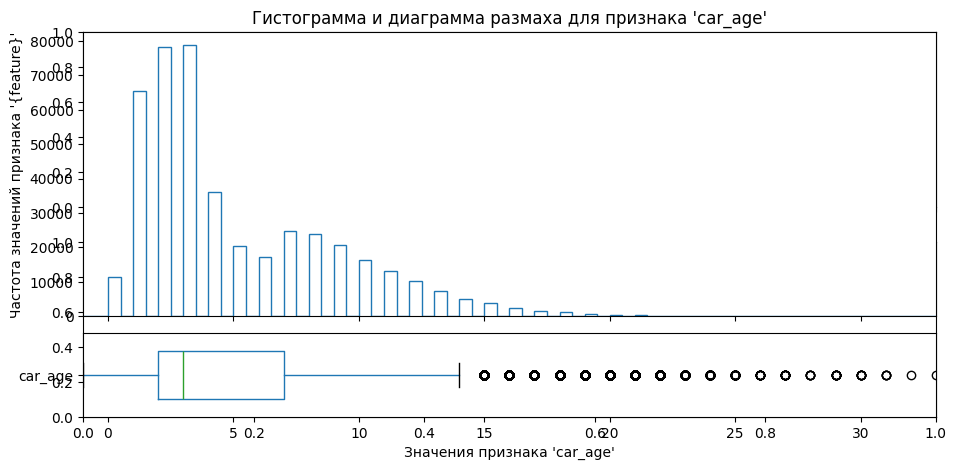

Количество выбросов в признаке car_age: 11021


,car_age_x,car_age_y
count,440234.0,110058.0
mean,4.9,4.8
std,4.0,3.9
min,-1.0,-1.0
25%,2.0,2.0
50%,3.0,3.0
75%,7.0,7.0
max,33.0,33.0


In [42]:
building_histogram_feature (df_train_research, 'car_age', 68, False)
print('Количество выбросов в признаке car_age:', output_number_emissions(df_train_research, 'car_age'))

pd.merge(df_train_research.car_age.describe().round(1), 
         df_test_research.car_age.describe().round(1), 
         left_index=True, right_index=True, how='outer')

In [43]:
print('Количество уникальных значений признаков:', df_train_research.car_age.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'car_age'))
print('Уникальные значения признака:', '\n', df_train_research.car_age.sort_values().unique())

Количество уникальных значений признаков: 35
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 2
Уникальные значения признака: 
 [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33]


Возраст автомобиля не может быть отрицательным, здесь может быть опечатка, выполним замену отрицательного значения на нулевое.

In [44]:
df_train_research['car_age'] = df_train_research['car_age'].replace(-1, 0)
df_test_research['car_age'] = df_test_research['car_age'].replace(-1, 0)

Основная доля автомобилей продаётся возрастом до 5 лет (59%). Автомобили от 5 до 10 лет вклчительно занимают 28% продаж. Остальные 70% возрастных категорий занимают менее 13% рынка. 

In [45]:
bar_chart = go.Bar(
    x=df_train_research.sale_month.value_counts().index,
    y=df_train_research.sale_month.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частоты продаж автомобилей по месяцам',
    xaxis=dict(title='Номер месяца'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

print('Количество уникальных значений признаков:', df_train_research.sale_month.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'sale_month'))
print('Уникальные значения признака:', '\n', df_train_research.sale_month.sort_values().unique())

Количество уникальных значений признаков: 8
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 0
Уникальные значения признака: 
 [ 1  2  3  4  5  6  7 12]


Основная доля продаж приходится на декабрь - март (72%), и второй пик продаж наблюдается с апреля по июль (28%). С августа по ноябрь продажи отсутствуют.

In [46]:
bar_chart = go.Bar(
    x=df_train_research.sale_dayofweek.value_counts().index,
    y=df_train_research.sale_dayofweek.value_counts().values
    )
layout = go.Layout(
    title='Столбчатая диаграмма частоты продаж автомобилей по месяцам',
    xaxis=dict(title='Номер месяца'),
    yaxis=dict(title='Количество проданных автомобилей'),
    )
fig = go.Figure(data=[bar_chart], layout=layout)
fig.show()

print('Количество уникальных значений признаков:', df_train_research.sale_dayofweek.nunique())
print('Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках:', count_unique_discrepancies(df_train_research, df_test_research, 'sale_dayofweek'))
print('Уникальные значения признака:', '\n', df_train_research.sale_dayofweek.sort_values().unique())

Количество уникальных значений признаков: 7
Количество несовпадающих уникальных объектов в обучающей и тестовойсвыборках: 0
Уникальные значения признака: 
 [0 1 2 3 4 5 6]


Основные продажи происходят со Вт по Ср (87%), значительно меньшаядоля в Пн, Пт (13%). По Сб и Вс продажи отсутствуют.

#### Расстояние, пройденное автомобилем с момента выпуска `'odometer'`

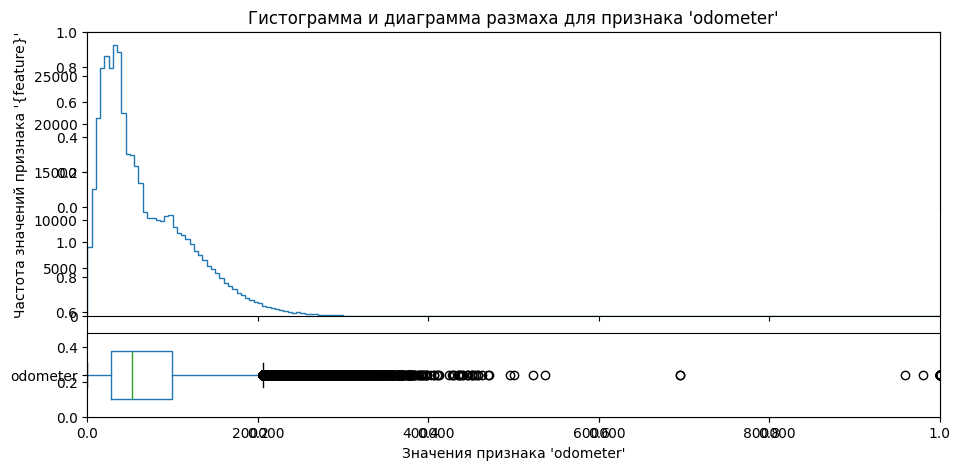

Количество выбросов в признаке odometer: 8152


,odometer_x,odometer_y
count,440234.0,110058.0
mean,68353.1,68086.0
std,53544.7,53524.4
min,1.0,1.0
25%,28259.2,28317.0
50%,52103.5,51935.0
75%,99283.0,98875.8
max,999999.0,999999.0


In [47]:
building_histogram_feature (df_train_research, 'odometer', 200, False)
print('Количество выбросов в признаке odometer:', output_number_emissions(df_train_research, 'odometer'))

pd.merge(df_train_research.odometer.describe().round(1), 
         df_test_research.odometer.describe().round(1), 
         left_index=True, right_index=True, how='outer')

Средний пробег автомобилей составляет 68К, однако он сильно отличается от медианного значения 52К, что связано с продажами автомобилей, имеющих длительный срок эксплуатации.

Распределение значений признака `'odometer'` более 600000 выглядят крайне сомнительно, построим scatterplot и оценим распределение в зависимости от возраста автомобиля.

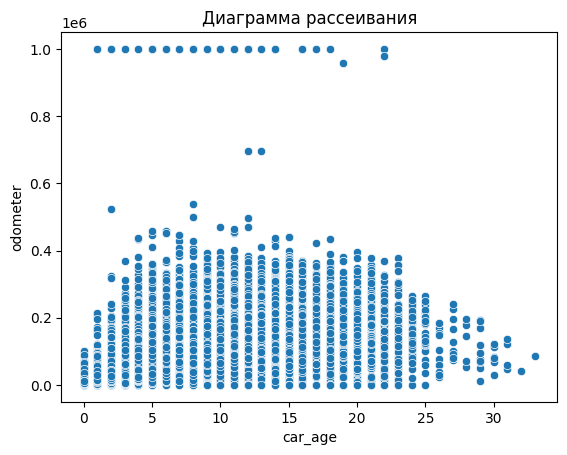

In [48]:
sns.scatterplot(x=df_train_research.car_age, y=df_train_research.odometer);
plt.title('Диаграмма рассеивания')
plt.show()

Разпределение значений милионников признака `'odometer'` выглядит очень неестественно, по крайней мере до 19 летнего возраста машины. Однако для лучшего обобщения основной массы значений моделью, обрежим данные по крайней мере на 600000, таким образом мы избавляемся всего от 34 автомобиля но значительно увеличим плотность распределения значения признака.

In [49]:
df_train_research = df_train_research.loc[df_train_research['odometer'] < 600000]

#### Снижение размерности категориальных признаков

В исследуемом наборе данных можно отметить обилие значений признаков с очень малыми частотами проявлений, вплоть до единиц штук. Такие признаки вряд ли могут быть полезны для задач прогнозирования, в следствии чего проведём исследование на вопрос возможности заменены наблюдаемых низкочастотных значений признаков на значения их частот, что снизит собственную размерность признаков и повысит стабильность обучаемой модели.

In [50]:
def reducing_dimension_feature_(data_train: pd.DataFrame, data_test: pd.DataFrame, feature: str, freq: int) -> pd.DataFrame:
    '''
    Функция заменяет значение признака таблицы, частота встречаемости которого ниже или равна установленному порогу
    data_train: pd.DataFrame - таблица с тренировочными данными
    data_train: pd.DataFrame - таблица с тестовыми данными
    feature: str - обрабатываемый признак
    return pd.DataFrame - на выходе две таблицы тренировочных и тестовых данных
    '''
    print('Количество уникальных значений признаков до замены:', data_train[feature].nunique())
    print('Количество несовпадающих уникальных объектов в df_train и df_test до замены:', count_unique_discrepancies(data_train, data_test, feature))

    for index, value in zip(data_train[feature].value_counts(ascending=True).index, 
                            data_train[feature].value_counts(ascending=True).values):
        if value <= freq:
            data_train[feature] = data_train[feature].replace(index, f'frequency {value}')
            data_test[feature] = data_test[feature].replace(index, f'frequency {value}')
        else:
            break

    print('Количество уникальных значений после замены признаков:', data_train[feature].nunique())
    print('Количество несовпадающих уникальных объектов в df_train и df_test после замены:', count_unique_discrepancies(data_train, data_test, feature))
    return data_train, data_test

In [51]:
# Алгоритм для проведения исследования результатов снижения размерности признаков
CALCULATION_OF_PARAMETERS = False
if CALCULATION_OF_PARAMETERS:
    feature = 'model' # Указываем признак для расчёта исследовательского графика

    X = df_train_research.drop('sellingprice', axis=1).drop('vin', axis=1).copy()
    y = df_train_research['sellingprice'].copy()

    num_cols = ['condition','odometer','car_age']
    cat_cols = list(set(X.columns) - set(num_cols))

    unique_freq = X[feature].value_counts(ascending=True).unique()

    scores_list = [] # Значение целевой метрики
    value_list = [] # Заменяемые частоты значений признака
    # Последовательная замена значений с наименьшей частотой и вычисление целевой метрики
    for freq in unique_freq[0:int(len(unique_freq)/np.log(len(unique_freq)))]:
        scores = []
        # Проверка качества замены на кросвалидации
        cv = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
        for train_index, test_index in cv.split(X, y):
            X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
            Y_train_cv, Y_test_cv = y.iloc[train_index], y.iloc[test_index]
            
            for vc_ind, vc_val in zip(X_train_cv[feature].value_counts(ascending=True).index,
                                      X_train_cv[feature].value_counts(ascending=True).values):
                if vc_val == freq:
                    X_train_cv[feature] = X_train_cv[feature].replace(vc_ind, f'frequency {freq}')
                    X_test_cv[feature] = X_test_cv[feature].replace(vc_ind, f'frequency {freq}')
                else:
                    if vc_val > freq:
                        break
            
            # Преобразование категориальных признаков в числовые
            encoder = ce.TargetEncoder().fit(X_train_cv[cat_cols], Y_train_cv)
            X_train_cv[cat_cols] = encoder.transform(X_train_cv[cat_cols])
            X_test_cv[cat_cols] = encoder.transform(X_test_cv[cat_cols])

            # Нормализация числовых признаков
            scaler = pr_ng.StandardScaler().fit(X_train_cv[cat_cols + num_cols])
            X_train_cv[cat_cols + num_cols] = scaler.transform(X_train_cv[cat_cols + num_cols])
            X_test_cv[cat_cols + num_cols] = scaler.transform(X_test_cv[cat_cols + num_cols])

            predict = Ridge(random_state=RANDOM_STATE).fit(
                np.ascontiguousarray(X_train_cv), 
                np.ascontiguousarray(Y_train_cv)
                ).predict(np.ascontiguousarray(X_test_cv))
            scores.append(mean_absolute_percentage_error(Y_test_cv.values, predict) * 100)

        for vc_ind, vc_val in zip(X_train_cv[feature].value_counts(ascending=True).index,
                                  X_train_cv[feature].value_counts(ascending=True).values):
            if vc_val == freq:
                X[feature] = X[feature].replace(vc_ind, f'frequency {freq}')
            else:
                if vc_val > freq:
                    break

        scores_list.append(np.mean(scores).round(3))
        value_list.append(freq)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=value_list, y=scores_list, mode='lines'))
    fig.update_layout(
        xaxis_title='Частота значения признака', 
        yaxis_title='Значение метрики MAPE, %', 
        title=f'Изменение метрики MAPE при замене значений признака {feature} с наименьшими частотами')
    fig.show()

In [52]:
# Год производства автомобиля seller
df_train_research, df_test_research = reducing_dimension_feature_(df_train_research, df_test_research, 'seller', 23)

Количество уникальных значений признаков до замены: 13024
Количество несовпадающих уникальных объектов в df_train и df_test до замены: 7537
Количество уникальных значений после замены признаков: 1879
Количество несовпадающих уникальных объектов в df_train и df_test после замены: 1071


<image src="https://sun9-19.userapi.com/impg/tjD3mz7QtVrYEg03n0KIzeFGzTNB_h-98XvVfg/mkIIcOoyKJc.jpg?size=1778x450&quality=95&sign=d5438d8c0fae4fa2c120d0812e9cabc5&type=album" alt="Изменение метрики MAPE при замене значений признака seller с наименьшими частотами"></img>

In [53]:
# Год производства автомобиля year
df_train_research, df_test_research = reducing_dimension_feature_(df_train_research, df_test_research, 'year', 4)

Количество уникальных значений признаков до замены: 34
Количество несовпадающих уникальных объектов в df_train и df_test до замены: 3
Количество уникальных значений после замены признаков: 33
Количество несовпадающих уникальных объектов в df_train и df_test после замены: 2


<image src="https://sun9-15.userapi.com/impg/qptY3GtZWbjrmm_B-jiH9BC4aLs_-WUQiT8EcA/CaeT8TiKZCk.jpg?size=1778x450&quality=95&sign=41d164c8129964fa1f0f482680d988e9&type=album" alt="Изменение метрики MAPE при замене значений признака year с наименьшими частотами"></img>

In [54]:
# Уровни отделки салона автомобиля (разные версии модели) trim
df_train_research, df_test_research = reducing_dimension_feature_(df_train_research, df_test_research, 'trim', 49)

Количество уникальных значений признаков до замены: 1951
Количество несовпадающих уникальных объектов в df_train и df_test до замены: 544
Количество уникальных значений после замены признаков: 528
Количество несовпадающих уникальных объектов в df_train и df_test после замены: 57


<image src="https://sun9-30.userapi.com/impg/ToGHOR1PC2JpmrbyP2AhbqTIiZgtWMI6pjJcpw/KQ8Yw-_gDps.jpg?size=1778x450&quality=95&sign=f8681ebe696bb07da4cc5abe9ae7a4e9&type=album" alt="Изменение метрики MAPE при замене значений признака trim с наименьшими частотами"></img>

In [55]:
# Тип кузова транспортного средства body
df_train_research, df_test_research = reducing_dimension_feature_(df_train_research, df_test_research, 'body', 28)

Количество уникальных значений признаков до замены: 61
Количество несовпадающих уникальных объектов в df_train и df_test до замены: 7
Количество уникальных значений после замены признаков: 55
Количество несовпадающих уникальных объектов в df_train и df_test после замены: 3


<image src="https://sun9-78.userapi.com/impg/ste8FWEPNCQ3uD-1xDvQWdu-y7I9fjksyoYYuw/b4cNpEoHdD8.jpg?size=1778x450&quality=95&sign=a6ab7ef8d9d736c86b22736fac116e30&type=album" alt="Изменение метрики MAPE при замене значений признака body с наименьшими частотами"></img>

In [56]:
# Издание автомобиля определенной марки model
df_train_research, df_test_research = reducing_dimension_feature_(df_train_research, df_test_research, 'model', 19)

Количество уникальных значений признаков до замены: 881
Количество несовпадающих уникальных объектов в df_train и df_test до замены: 125
Количество уникальных значений после замены признаков: 625
Количество несовпадающих уникальных объектов в df_train и df_test после замены: 12


<image src="https://sun9-69.userapi.com/impg/H9_lW96pl37q6BkBwbNUE5eIZiWw37UOO_WDxQ/xgJ41XDdzwI.jpg?size=1778x450&quality=95&sign=200be76664dbedb8662be962898dd1cf&type=album" alt="Изменение метрики MAPE при замене значений признака model с наименьшими частотами"></img>

Результаты оптимизации размерности признаков:
- Количество уникальных значений для признака seller уменьшено на 85,6%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 43%.
- Количество уникальных значений для признака year уменьшено на 2,9%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 33,3%.
- Количество уникальных значений для признака trim уменьшено на 71,4%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 89,5%.
- Количество уникальных значений для признака body уменьшено на 9,8%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 57,1%.
- Количество уникальных значений для признака model уменьшено на 29,1%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 90,4%.

### Исследование мультиколлиниарности

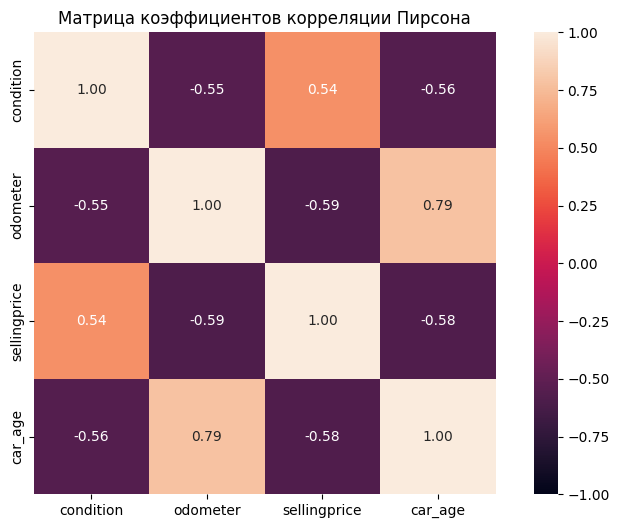

In [57]:
num_cols = ['condition','odometer','sellingprice','car_age']

f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_train_research[num_cols].corr(), vmin=-1, vmax=1, square=True, annot=True, fmt='.2f');
plt.title('Матрица коэффициентов корреляции Пирсона')
plt.show()

Наибольший положительный коэффициент корреляции (0,79) наблюдается для признаков `'odometer'` и `'car_age'`, что естественно, чем старше автомобиль, тем больше он обычно проезжает. Отрицательное направление коэффициента корреляции даёт признак condition, чем дольше и сильнее эксплуатируется автомобиль, тем более удручающее его состояние.

In [58]:
cat_cols = list(set(df_train_research.columns) - set(num_cols))

CALCULATION_OF_PARAMETERS = False
if CALCULATION_OF_PARAMETERS:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df_train_research.drop(['vin'], axis=1).phik_matrix(interval_cols=num_cols), vmin=0, vmax=1, square=True, annot=True, fmt='.2f')
    plt.title('Матрица коэффициентов корреляции Фи (Phi) обработанных данных')
    plt.show()

<image src="https://sun9-56.userapi.com/impg/-5mr_7wD92uq8zn9RXz6qU1N4841y_Pmej7s1g/gwtoHhksCuo.jpg?size=865x778&quality=95&sign=4ea5db1df0fd3877b5c9ce049042ec9d&type=album" alt="Матрица коэффициентов корреляции Фи (Phi) обработанных данных"></img>

- Сильные корреляции наблюдаются между признаками `'make'`, `'model'` и `'trim'`, поскольку по сути они в целом отражают то, что из себя сам автомобиль представляет в вакууме. Между тем эти признаки не являются полностью взаимозаменяемыми.
- Сильная корреляция наблюдается между `'model'` и `'body'`, вполне вероятно от части по причине применения методики заполнения пропусков второго признака по первому, а также по причине того, что одинаковые модели как правила имеют схожие типы кузовов.
- Довольно значимые типы корреляции наблюдаются между признаком `'seller'` и признаками `'make'`, `'state'`, вероятно потому, что продавцы могут специализировать на продаже однотипных марок или состояний автомобилей.

### Выводы

- **Год выпуска автомобиля `'year'`**. Основная доля проданных автомобилей относится к 2011-2014 гг. С 1988 года происходил планомерный рост продаж, только в 2015 наблюдается резкий спад, что возможно связано с кризисом 2014 года. Очень малая доля продаж автомобилей до 1989 года производства, вероятно есть смысл обьединить их в одну категорию, для того, что бы моделе не пришлось предсказывать очень редкие события.
- **Марка автомобиля `'make'`**. Самой продаваемой маркой автомобиля является ford, так же хорошие продажи у chevrolet, nissan, toyota, dodge и honda. Сгрупированы редкие марки автомобилей с числом продаж менее 8 в признак rare make сократило пространство значений признака с 63 до 51 (19%).
- **Издание автомобиля определенной марки `'model'`**. Наиболее продаваемые марки автомобилей, с продажами свыше 10К: altima, f-150, fusion, camry, которые занимают 10,7% рынка. Марки с продажами от 10К до 5К занимают 28,8%, хотя эта группа составляет уже 16 марок автомобилей. В данных обнаруженно 42 кросплатформенные модели. Сгруппированны редкие модели автомобилей с числом продаж менее 2 в признак rare model сократила пространство значений признака с 840 до 754 (10%).
- **Уровни отделки салона автомобиля (разные версии модели) `'trim'`**. Различные уровни отделки салона автомобиля могут быть у одной и той же модели (2543 пересечений). Грипировка редких событий с числом продаж менее 1 в признак rare trim сократила пространство значений признака с 1841 до 1593 (13,5%).
- **Тип кузова транспортного средства `'body'`**. Наиболее часто продаваемые типы кузовов являются sedan и suv и составляют 69%, ещё 17 последующих типов составляет 30% продаж. При этом 58% типов кузовав составляет менее 1% продаж. Грипировка редких типов кузовов автомобилей с числом продаж менее 6 в признак rare body сократило пространство значений признака с 46 до 43 (6,5%).
- **Механизм, который передает мощность от двигателя к колесам `'transmission'`**. Наиболее часто встречающийся тип трансмиссии в продаваемых машинах это автоматика и составляет 97%.
- **Идентификационный номер транспортного средства `'vin'`**. Количество уникальных значений признака на 100% совпадает с размером DF, что свидетельствует об отсутствии классификационной значимости.
- **Cостояние, в котором автомобиль выставлен на аукцион `'state'`**. Половина продаваемых автомобилей относится к состояниям: fl, ca, pa, tx и ga.
- **Состояние автомобилей на момент аукциона `'condition'`**. Распределение значений признака имеет точно очерченные границы (от 1 до 5), поскольку он является мерой оценки. В целом можно отметить что "центр массы распределения" смещён правее к 3,6-3,4. Однако явно виден провал частот от 1 до 1,9 с сильным нетипичным пиком на 1,9, складывается ощущение, что этот пик и вобрал на себя весь провал частот распределения до его.
- **Цвет кузова автомобиля `'color'`**. Наиболее часто продаваемые расцветки black и white (39%), silver и gray (30%), blue и red (17%). Явно наблюдается некоторое подобие попарной корреляций цветов автомобиля, перечисленных ранее. Остальные 68% расцветок занимают менее 14% продаж.
- **Цвет салона автомобиля `'interior'`**. Наиболее часто продаваемые расцветки салона black и gray (76%), beige и tan (19%). Остальные 77% расцветок занимают менее 5% продаж.
- **Продавец автомобиля, автосалоны `'seller'`**. Признак `seller` имеет большое количество уникальных значений и огромное количество несовпадений со значениями в тестевой выборки. Групировка редких событий с числом продаж менее 3 в признак rare seller, сократило пространство значений признака с 13025 до 5572 (57,2%).
- **Цена, по которой автомобиль был продан на аукционе `'sellingprice'`**. Высокий диапазон разброса значений цены продажи (от 100 до 230К) характеризует большая дисперсия 9,7К. Среднее значение цены (13,6К) заметно превышает медианного значение (12,1К) из-за наличия большого количества выбросов в данных (13,8К). Избавляться от выбросов не разумно, поскольку они вероятно представляют отдельный сегмент рынка продажи автомобилей.
- **Возраст автомобиля `'car_age'`**. Основная доля автомобилей продаётся возрастом до 5 лет (59%). Автомобили от 5 до 10 лет вклчительно занимают 28% продаж. Остальные 70% возрастных категорий занимают менее 13% рынка.
- **Месяц продажи автомобиля `'sale_month'`**. Основная доля продаж приходится на декабрь - март (72%), и второй пик продаж наблюдается с апреля по июль (28%). С августа по ноябрь продажи отсутствуют.
- **Неделя продажи автомобиля `'sale_dayofweek'`**. Основные продажи происходят со Вт по Ср (87%), значительно меньшаядоля в Пн, Пт (13%). По Сб и Вс продажи отсутствуют.
- **Расстояние, пройденное автомобилем с момента выпуска `'odometer'`**. Средний пробег автомобилей составляет 68К, однако он сильно отличается от медианного значения 52К, что связано с продажами автомобилей, имеющих длительный срок эксплуатации. Распределение значений признака `'odometer'` более 600000 выглядят крайне сомнительно, поэтому они были отфильтрованы.

## Разработка модели ML

In [59]:
# Сохранение и загрузка промежуточных результатов
RESEARCH = False
if RESEARCH:
    df_train_research.to_csv('Cars_train_research.csv', index=False)
    df_test_research.to_csv('Cars_test_research.csv', index=False)
else:
    df_train = pd.read_csv('Cars_train_research.csv')
    df_test = pd.read_csv('Cars_test_research.csv')

    display(df_train.head())

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,car_age,sale_month,sale_dayofweek
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,4,6,1
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,1,2,2
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,3,6,2
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,12,6,2
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,8,2,1


### Подбор оптимальной ML на дефолтных параметрах

In [60]:
# Определяем признаки, которые будут удалены из исследования
features_drop = ['vin']

# Отфильтровываем дубликаты
print(f'Количество дубликатов: {df_train.drop(features_drop, axis=1).duplicated().sum()}')
df_train = df_train.drop(features_drop, axis=1).dropna()

X_train = df_train.drop('sellingprice', axis=1).copy()
Y_train = df_train['sellingprice'].copy()
X_test = df_test.drop(features_drop, axis=1).copy()

num_cols = ['condition','odometer','car_age']
cat_cols = list(set(X_train.columns) - set(num_cols))

print('Размеры выборок:', X_train.shape, X_test.shape, Y_train.shape)

Количество дубликатов: 0
Размеры выборок: (440175, 15) (110058, 15) (440175,)


In [61]:
# Список зипланированных к использованию методов
scaler_type = [
    pr_ng.StandardScaler(),
    pr_ng.MinMaxScaler(),
    pr_ng.RobustScaler(),
    pr_ng.MaxAbsScaler(),
    pr_ng.Normalizer()
]
encoder_type = [
    ce.TargetEncoder(),
    ce.QuantileEncoder(),
    ce.OrdinalEncoder(),
    ce.MEstimateEncoder(),
    ce.LeaveOneOutEncoder(),
    ce.JamesSteinEncoder(),
    ce.HashingEncoder(),
    ce.GLMMEncoder(),
    ce.CountEncoder(),
    ce.CatBoostEncoder(),
    ce.BinaryEncoder(),
    ce.BaseNEncoder()
]
models_type = [
    ('ridge', Ridge(random_state=RANDOM_STATE)),
    ('lasso', Lasso(random_state=RANDOM_STATE)),
    ('Linear', LinearRegression()),
    ('DecisionTree', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ('elasticnet', ElasticNet(random_state=RANDOM_STATE)),
    ('kneighbors', KNeighborsRegressor()),
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_STATE, tree_method='gpu_hist', predictor='gpu_predictor', verbosity=0)),
    ('lgbm', lgb.LGBMRegressor(verbosity=-1, random_state=RANDOM_STATE)),
    ('gradientboosting', HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
    ('catboost', CatBoostRegressor(eval_metric='MAPE', verbose=False, task_type='GPU', devices='0:1', random_state=RANDOM_STATE)),
    ('random_forest', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
]

In [62]:
# Подбор оптимального алгоритма обработки признаков
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
    column_cat_transf = ColumnTransformer(transformers=[
        ('encoder', ce.TargetEncoder(), cat_cols)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('preproc_cat', column_cat_transf),
        ('num_pipe', num_pipe),
        ('classifier', None)
    ])
    param_grid = {
        'preproc_cat__encoder': encoder_type,
        'num_pipe__scaler': scaler_type
    }
    for name, model in models_type:
        pipeline.set_params(classifier=model)
        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            n_jobs=6,
            scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
        )
        grid.fit(X_train, Y_train)
        print(f'{name}: {grid.best_params_}, {np.round(grid.best_score_*100,3)*-1} %')

Таблица результатов подбора оптимальных алгоритмов обработки признаков.

| Модели классификации          | scaler         | encoder            | MAPE % |
| ----------------------------- | -------------- | ------------------ | ------ |
| Ridge                         | Normalizer     | CatBoostEncoder    | 49.833 |
| Lasso                         | Normalizer     | CatBoostEncoder    | 49.941 |
| LinearRegression              | Normalizer     | TargetEncoder      | 48.321 |
| DecisionTreeRegressor         | MinMaxScaler   | GLMMEncoder        | 22.213 |
| ElasticNet                    | StandardScaler | TargetEncoder      | 50.774 |
| KNeighborsRegressor           | Normalizer     | BinaryEncoder      | 23.035 |
| XGBRegressor                  | StandardScaler | GLMMEncoder        | 18.250 |
| LGBMRegressor                 | MinMaxScaler   | GLMMEncoder        | 21.041 |
| HistGradientBoostingRegressor | RobustScaler   | GLMMEncoder        | 21.184 |
| CatBoostRegressor             | MinMaxScaler   | GLMMEncoder        | 18.064 |
| RandomForestRegressor         | RobustScaler   | JamesSteinEncoder  | 16.637 |

Лучшие результаты показали модели XGBRegressor, CatBoostRegressor и RandomForestRegressor, которые дают на безлайне значение целевой метрики в диапазоне 18,5-16,5%. От модели RandomForestRegressor решено отказать по причине отсутствия достаточного обьёма вычислительных ресурсов.

### Оценка влияния признаков на качество обучения модели

In [63]:
# Оценка важности признаков на основе перестановок
CALCULATION_OF_PARAMETERS = False
if CALCULATION_OF_PARAMETERS:
    np.random.seed(RANDOM_STATE)
    X_train_perm = X_train.copy()

    # Преобразование категориальных признаков в числовые
    encoder = ce.GLMMEncoder().fit(X_train_perm[cat_cols], Y_train)
    X_train_perm[cat_cols] = encoder.transform(X_train_perm[cat_cols])

    # Нормализация числовых признаков
    scaler = pr_ng.StandardScaler().fit(X_train_perm[cat_cols + num_cols])
    X_train_perm[cat_cols + num_cols] = scaler.transform(X_train_perm[cat_cols + num_cols])

    # Добавляем случайные признаки с равномерным и нормальным распределениями
    X_train_perm['uniform'] = np.random.uniform(-1, 1, len(X_train_perm))
    X_train_perm['normal'] = np.random.normal(-1, 1, len(X_train_perm))

    m_dtc = xgb.XGBRegressor(random_state=RANDOM_STATE, tree_method='gpu_hist', predictor='gpu_predictor', verbosity=0)
    m_dtc.fit(X_train_perm, Y_train)

    result = permutation_importance(m_dtc, X_train_perm, Y_train, n_repeats=10, random_state=RANDOM_STATE)
    sorted_idx = result.importances_mean.argsort()
    plt.barh(X_train_perm.columns[sorted_idx], result.importances_mean[sorted_idx])
    plt.xlabel('Важность признака')
    plt.title('Оценка важности признаков на основе перестановок')
    plt.show()

<image src="https://sun9-40.userapi.com/impg/zJdkaUpsqQdNSQSTXhOl3owC2bfoI62wr3ed6w/5RuMW3MvoU8.jpg?size=636x455&quality=95&sign=a6c74ba5af72920ffe98950f9c4b808d&type=album" alt="Оценка важности признаков на основе перестановок">

Исходя из проделанного теста все признаки обладают классифицирующими свойствами лучше, чем случайный набор значений. Удаление некоторых признаков одназначло приводит к увеличению значения целевой метрики безлайновых моделей.

### Обучение и тестирование модели

In [64]:
# Подбор оптимальных гиперпараметров для XGBRegressor
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        if trial.suggest_categorical('depth', [True, False]): # Максимальная глубина дерева, по умолчанию None
            max_depth = trial.suggest_int('max_depth', 10, 20)
        else:
            max_depth = None

        model = xgb.XGBRegressor(
            random_state=RANDOM_STATE, # Определение случайности для разделения на узлы
            tree_method='gpu_hist', predictor='gpu_predictor', # Вычисления на GPU
            verbosity=0,
            objective='reg:squarederror', # Целевая функция для регрессии
            max_depth=max_depth, # Функция потерь, которая оптимизируется при обучении модели, по умолчанию reg:squarederror
            learning_rate=trial.suggest_float('learning_rate', 0.001, 0.3, step=0.001), # Скорость обучения модели, по умолчанию 0.3
            n_estimators=trial.suggest_int('n_estimators', 10, 1000), # Количество базовых моделей (деревьев) в ансамбле, по умолчанию 100
            booster=trial.suggest_categorical('booster', ['gbtree','gblinear']), # Тип базовых моделей, которые используются в ансамбле, по умолчанию 'gbtree' ('dart' требует много вычислений)
            gamma=trial.suggest_float('gamma', 0, 10, step=0.01), # Минимальное изменение функции потерь, которое требуется для создания нового разделения в базовых деревьях, по умолчанию 0
            min_child_weight=trial.suggest_float('min_child_weight', 0, 10, step=0.01), # Минимальный вес дочернего узла, по умолчанию 1
            subsample=trial.suggest_float('subsample', 0.1, 1, step=0.01), # Доля образцов, используемых для обучения каждого базового дерева, по умолчанию 1
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.1, 1, step=0.01), # Доля признаков, используемых для обучения каждого базового дерева, по умолчанию 1
            colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.5, 1, step=0.01), # Доля признаков для каждого уровня дерева, по умолчанию 1
            colsample_bynode=trial.suggest_float('colsample_bynode', 0.5, 1, step=0.01), # Доля признаков для каждого разбиения узла, по умолчанию 1
            reg_alpha=trial.suggest_float('reg_alpha', 0, 10, step=0.01), # Коэффициент регуляризации для L1-регуляризации базовых деревьев, по умолчанию 0
            reg_lambda=trial.suggest_float('reg_lambda', 0, 10, step=0.01), # Коэффициент регуляризации для L2-регуляризации базовых деревьев, по умолчанию 1
            base_score=0.5, # Базовый прогноз, используется при инициализации, по умолчанию 0.5
            )
        num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.GLMMEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', model)])
        scores = cross_val_score(estimator=pipeline, X=X_train, y=Y_train, scoring=make_scorer(mean_absolute_percentage_error), cv=5)
        return np.mean(scores)

    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                study_name='XGBRegressor',
                                storage='sqlite:///my_study_XGBRegressor.db',
                                load_if_exists=True
                                )
    study.optimize(objective, n_trials=None, timeout=None, n_jobs=-1)
else:
    print('''
Количество завершенных испытаний: 143
Лучшее испытание завершено на итерации: 138
Лучшее значение целевой метрики: 0.13631015479033698
''')
    mxgb = xgb.XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method='gpu_hist', predictor='gpu_predictor',
        objective='reg:squarederror',
        verbosity=0,
        n_estimators=380,
        learning_rate=0.06,
        max_depth=15,
        booster='gbtree',
        gamma=6.35,
        min_child_weight=5.63,
        subsample=0.74,
        colsample_bytree=0.94,
        colsample_bylevel=0.66,
        colsample_bynode=0.89,
        reg_alpha=5.17,
        reg_lambda=5.87
        )
    num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.GLMMEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', mxgb)])
    scores = cross_val_score(estimator=pipeline, X=X_train, y=Y_train, scoring=make_scorer(mean_absolute_percentage_error), cv=5)

    print(F'Значение MAPE: {np.round(np.mean(scores)*100,3)} %')


Количество завершенных испытаний: 143
Лучшее испытание завершено на итерации: 138
Лучшее значение целевой метрики: 0.13631015479033698



Значение MAPE: 13.623 %


Лучший результат: `Trial 138 finished with value: 0.13631015479033698 and parameters: {'depth': True, 'max_depth': 15, 'learning_rate': 0.06, 'n_estimators': 380, 'booster': 'gbtree', 'gamma': 6.35, 'min_child_weight': 5.63, 'subsample': 0.74, 'colsample_bytree': 0.94, 'colsample_bylevel': 0.66, 'colsample_bynode': 0.89, 'reg_alpha': 5.17, 'reg_lambda': 5.87}`

In [65]:
# Подбор оптимальных гиперпараметров для CatBoostRegressor
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        
        od_type=trial.suggest_categorical('od_type', [None,'Iter','IncToDec']) # Тип детектора переобучения, используемого во время обучения, по умолчанию None
        od_pval=None
        od_wait=None
        if od_type == 'Iter':
            od_wait=trial.suggest_int('od_wait', 20, 100, step=5) # Определяет количество итераций, которые должны пройти после последней лучшей итерации, по умолчанию 20
        elif od_type == 'IncToDec':
            od_pval=trial.suggest_float('od_pval', 1e-10, 1e-2, step=1e-10) # Определяет порог для типа детектора переобучения IncToDec

        loss_function=trial.suggest_categorical('loss_function', ['RMSE','Quantile','Poisson']) # Функция потерь, которую необходимо оптимизировать, по умолчанию RMSE
        leaf_estimation_method=None
        if loss_function == 'MAE' or loss_function == 'Quantile':
            leaf_estimation_method='Gradient'  # Метод, используемый для расчета значений в листьях

        bootstrap_type=trial.suggest_categorical('bootstrap_type', [None,'Bayesian','MVS','Poisson']) # Определяет метод выборки весов объектов
        subsample=None 
        if bootstrap_type == 'Poisson' or bootstrap_type == 'Bernoulli' or bootstrap_type == 'MVS':
            subsample=trial.suggest_float('subsample', 0.1, 1, step=0.01) # Определяет долю объектов, которые будут использоваться при каждом шаге бустинга
        
        model = CatBoostRegressor(
            iterations=trial.suggest_int('iterations', 4000, 10000, step=10), # Количество итераций обучения, по умолчанию 1000
            learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.5), # Скорость обучения, по умолчанию 0.03
            depth=trial.suggest_int('depth', 1, 12, step=1), # Максимальная глубина дерева, по умолчанию 6
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.001, 100, log=True), # Коэффициент L2-регуляризации, по умолчанию 1
            border_count=trial.suggest_int('border_count', 155, 305, step=5), # Количество разбиений для числовых признаков, по умолчанию 255
            feature_border_type=trial.suggest_categorical('feature_border_type', [None,'GreedyLogSum','Uniform','Median','MaxLogSum','MinEntropy']), # Определяет способ выбора границ для числовых признаков
            counter_calc_method=trial.suggest_categorical('counter_calc_method', [None,'SkipTest']), # Метод расчета счетчиков для категориальных признаков
            random_strength=trial.suggest_float('random_strength', 0., 1), # Насколько случайными будут градиентные деревья, по умолчанию 1
            bagging_temperature=trial.suggest_float('bagging_temperature', 0, 5), # Насколько сильно использовать байесовский бэггинг, по умолчанию 1
            fold_len_multiplier=trial.suggest_float('fold_len_multiplier', 1, 6), # Коэффициент длины блока, по умолчанию 2
            score_function=trial.suggest_categorical('score_function', [None,'L2','Cosine']), # Используется для определения функции оценки, которая измеряет качество приближения градиента
            leaf_estimation_backtracking=trial.suggest_categorical('leaf_estimation_backtracking', [None,'AnyImprovement','Armijo']), # Определяет тип отката, который будет использоваться во время градиентного спуска
            penalties_coefficient=trial.suggest_float('penalties_coefficient', 0., 2), # Общий коэффициент для умножения всех штрафов
            langevin=trial.suggest_categorical('langevin', [True,False]), # Включает режим Stochastic Gradient Langevin Boosting
            eval_metric='MAPE', # Метрика для оценки качества модели во время обучения, по умолчанию RMSE
            verbose=False,
            task_type='GPU',
            devices='0:1',
            leaf_estimation_method=leaf_estimation_method,
            bootstrap_type=bootstrap_type, 
            loss_function=loss_function, 
            subsample=subsample,
            od_type=od_type,
            od_pval=od_pval,
            od_wait=od_wait,
            random_state=RANDOM_STATE,
            )
        num_pipe = Pipeline([('scaler', pr_ng.MinMaxScaler())])
        column_transf = ColumnTransformer(transformers=[('encoder', ce.GLMMEncoder(), cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', model)])
        scores = cross_val_score(estimator=pipeline, X=X_train, y=Y_train, scoring=make_scorer(mean_absolute_percentage_error), cv=5)
        return np.mean(scores)

    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                study_name='CatBoostRegressor',
                                storage='sqlite:///my_study_CatBoostRegressor.db',
                                load_if_exists=True
                                )
    study.optimize(objective, n_trials=None, timeout=None, n_jobs=1)
else:
    print('''
Количество завершенных испытаний: 184
Лучшее испытание завершено на итерации: 147
Лучшее значение целевой метрики: 0.12502808872973376
''')
    m_cbr = CatBoostRegressor(
            od_type=None,
            loss_function='Poisson', 
            bootstrap_type='Poisson', 
            subsample=0.99,
            iterations=11860,
            learning_rate=0.1202547960930698,
            depth=8,
            l2_leaf_reg=1.2001175154436945,
            border_count=285,
            feature_border_type='MaxLogSum',
            counter_calc_method=None,
            random_strength=0.8961295506311359,
            bagging_temperature=4.358835994451879,
            fold_len_multiplier=3.192815423484482,
            score_function='L2',
            leaf_estimation_backtracking=None,
            penalties_coefficient=0.8284163621563814,
            langevin=False,
            eval_metric='MAPE',
            verbose=False,
            task_type='GPU',
            devices='0:1',
            leaf_estimation_method=None,
            od_pval=None,
            od_wait=None,
            random_state=RANDOM_STATE,
        )
    num_pipe = Pipeline([('scaler', pr_ng.MinMaxScaler())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.GLMMEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', m_cbr)])
    scores = cross_val_score(estimator=pipeline, X=X_train, y=Y_train, scoring=make_scorer(mean_absolute_percentage_error), cv=5)

    print('Значение MAPE:', np.round(np.mean(scores)*100,3))
    print('Значение std MAPE:', np.round(np.std(scores)*100,3))
    print('95% доверительный интервал:', (st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]*100).round(3))


Количество завершенных испытаний: 184
Лучшее испытание завершено на итерации: 147
Лучшее значение целевой метрики: 0.12502808872973376

Значение MAPE: 12.504
Значение std MAPE: 0.098
95% доверительный интервал: 12.775


Лучший результат: `Trial 147 finished with value: 0.12502808872973376 and parameters: {'od_type': None, 'loss_function': 'Poisson', 'bootstrap_type': 'Poisson', 'subsample': 0.99, 'iterations': 11860, 'learning_rate': 0.1202547960930698, 'depth': 8, 'l2_leaf_reg': 1.2001175154436945, 'border_count': 285, 'feature_border_type': 'MaxLogSum', 'counter_calc_method': None, 'random_strength': 0.8961295506311359, 'bagging_temperature': 4.358835994451879, 'fold_len_multiplier': 3.192815423484482, 'score_function': 'L2', 'leaf_estimation_backtracking': None, 'penalties_coefficient': 0.8284163621563814, 'langevin': False}`

### Выводы

Наилучший результат получен при использовании CatBoostRegressor. При установленной величине достаточности метрики качества МАРЕ, равной 20%, получен сильный результат, равный 12,5%. Качество модели весьма сильное, на что указывает низкое значение стандартного отклонения 0,093 и величина 95%-го доверительного интервала 12,25-12,77% при 5 использованных фолдах.

## Разработка мультимодельного подхода для ML

С целью поиска подхода по улучшению значения целевой метрики, решено исследовать вариант расчленения исследуемой выборки на наиболее схожие часть и исследовать их по отдельности. Самый сильный коэффициент корреляции Фи связи с целевым признаком `'sellingprice'` принадлежит признаку `'model'`. Рассмотрим медианное значение стоимости продаваемых моделей автомобилей.

In [66]:
median_prices = df_train.groupby(by='model').sellingprice.mean().sort_values()
price_std = df_train.groupby(by='model').sellingprice.std()

fig = go.Figure()
fig.add_trace(go.Scatter(x=median_prices.index, y=median_prices.values, mode='lines', name='Медианная стоимость'))
fig.add_trace(go.Scatter(x=price_std.index, y=price_std.values, mode='markers', name='Стандартное отклонение'))
fig.update_layout(
    xaxis_title='Модель автомобиля',
    yaxis_title='Статистика',
    title='Медианная стоимость и стандартное отклонение стоимости моделей автомобилей')
fig.update_xaxes(tickangle=90)
fig.show()

Очевидно, что различные модели автомобилей имеют свой характерный стоимостной диапазон, таким образом можно разделить тренировочную выборку на под выборки, которые характеризовались бы своим собственным, отличным от остальных, медианным значением целевого признака.

Разработаем алгоритм, который будет разделять модельный ряд по медианной стоимости моделей автомобилей, в зависимости от подобранных квантилей. Далее на основе подобранных списков моделей, делить собственно DF и оценивать качество обучения моделей на дефолтных параметрах методом кросвалидации.

In [67]:
# Функция для разделения выборки на подвыборки
def sampling_df_(df_train: pd.DataFrame, df_test: pd.DataFrame, feature: str, feature_target: str, quantiles: list) -> list:
    '''
    The algorithm creates lists of car models depending on 
    the target feature and divides DF based on the fitted lists
    df_train: pd.DataFrame - table with feature
    df_test: pd.DataFrame - table with feature
    feature: str - car models
    feature_target: str - target feature
    quantiles: float - model range division quantile
    return: [list, pd.DataFrame, pd.Series, pd.DataFrame, list] - list
    '''
    group_df_train = df_train.groupby(by='model')['sellingprice'].median().sort_values()

    indices = [] # список моделей для подвыборок
    for i in range(len(quantiles)): # создаём список моделей по заданым квантилям
        if len(quantiles) == 1:
            indices.append(group_df_train[group_df_train < group_df_train.quantile(quantiles[i])].index)
            indices.append(group_df_train[group_df_train >= group_df_train.quantile(quantiles[i])].index)
        elif i == 0:
            indices.append(group_df_train[group_df_train < group_df_train.quantile(quantiles[i])].index)
        elif quantiles[i] == quantiles[-1]:
            indices.append(group_df_train[(group_df_train >= group_df_train.quantile(quantiles[i-1]))&
                                        (group_df_train < group_df_train.quantile(quantiles[i]))].index)
            indices.append(group_df_train[group_df_train >= group_df_train.quantile(quantiles[i])].index)
        else:
            indices.append(group_df_train[(group_df_train >= group_df_train.quantile(quantiles[i-1]))&
                                        (group_df_train < group_df_train.quantile(quantiles[i]))].index)
            
    dfs_train = [] # список подвыборок обучающей выборки
    lambdas = [] # список значений lambda преобразования boxcox для подвыборок
    for i in range(len(indices)): # создаём подвыборки обучающей выборки
        df_train_subset = df_train[df_train[feature].isin(indices[i])]
        df_train_subset[feature_target], lamb = st.boxcox(df_train_subset[feature_target])
        dfs_train.append(pd.DataFrame(df_train_subset, columns=df_train.columns))
        lambdas.append(lamb)

    dfs_test_split = [] # список подвыборок тестевой выборки
    for i in range(len(indices)): # создаём подвыборки тестевой выборки
        dfs_test_split.append(df_test[df_test[feature].isin(indices[i])].copy())

    X_split = [] # список подвыборок с тренировочными признаками
    y_split = [] # список подвыборок с целевым признаком
    for i in range(len(dfs_train)): # делим подвыборки на тренировочные и целевой признаки
        X_split.append(dfs_train[i].drop(feature_target, axis=1).copy())
        y_split.append(dfs_train[i][feature_target].copy())

    return lambdas, X_split, y_split, dfs_test_split, indices

In [68]:
# Проводим поиск значений квантилей, дающих минимальное количество выбрасов
CALCULATION_OF_PARAMETERS = False
if CALCULATION_OF_PARAMETERS:
    def objective(trial: optuna.Trial):

        q_01 = trial.suggest_float('q_01', 0.0, 0.993, step=0.0001)
        q_02 = trial.suggest_float('q_02', q_01+0.001, 0.994, step=0.0001)
        q_03 = trial.suggest_float('q_03', q_02+0.001, 0.995, step=0.0001)
        q_04 = trial.suggest_float('q_04', q_03+0.001, 0.996, step=0.0001)
        q_05 = trial.suggest_float('q_05', q_04+0.001, 0.997, step=0.0001)
        q_06 = trial.suggest_float('q_06', q_05+0.001, 0.998, step=0.0001)
        q_07 = trial.suggest_float('q_07', q_06+0.001, 0.999, step=0.0001)
        q_08 = trial.suggest_float('q_08', q_07+0.001, 1.0, step=0.0001)

        quantiles_list = [q_01,q_02,q_03,q_04,q_05,q_06,q_07,q_08]

        try:
            lambdas, X_split, y_split, dfs_test_split, indices = sampling_df_(df_train, df_test, 'model', 'sellingprice', quantiles_list)

            emissions = 0
            for i in range(len(y_split)):
                perc_max = (np.percentile(y_split[i], 75) - np.percentile(y_split[i], 25)) * 1.5 + np.percentile(y_split[i], 75)
                perc_min = np.percentile(y_split[i], 25) - (np.percentile(y_split[i], 75) - np.percentile(y_split[i], 25)) * 1.5
                emissions += y_split[i][(y_split[i] < perc_min)|(y_split[i] > perc_max)].count()

            return emissions
        
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner()
                                )
    study.optimize(objective, n_trials=5000, timeout=None, n_jobs=-1)
else:
    m_cbr = CatBoostRegressor(
            eval_metric='MAPE',
            verbose=False,
            task_type='GPU',
            devices='0:1',
            random_state=RANDOM_STATE
        )
    num_pipe = Pipeline([('scaler', pr_ng.MinMaxScaler())])
    column_transf = ColumnTransformer(transformers=[('encoder', ce.GLMMEncoder(), cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', m_cbr)])

    lambdas, X_split, y_split, dfs_test_split, indices = sampling_df_(df_train, df_test, 'model', 'sellingprice', [0.96727])

    scores_full = 0
    for i in range(len(y_split)):
        scores = cross_val_score(estimator=pipeline, X=X_split[i], y=y_split[i], scoring=make_scorer(mean_absolute_percentage_error), cv=5)
        scores_full =+ np.mean(scores) * (len(y_split[i])/len(df_train))

    print('Значение MAPE:', np.round(scores_full*100, 4))

Значение MAPE: 0.0198


- `Trial 0122 from 1000 finished with value: 2600 and parameters: {'q_01': 0.96727}` MAPE: 5.5465
- `Trial 0182 from 1000 finished with value: 2452 and parameters: {'q_01': 0.91725, 'q_02': 0.95944}` MAPE: 3.4886
- `Trial 1652 from 3000 finished with value: 2407 and parameters: {'q_01': 0.9171, 'q_02': 0.9586, 'q_03': 0.9866}` MAPE: 9.7201
- `Trial 1147 from 3000 finished with value: 2403 and parameters: {'q_01': 0.9168, 'q_02': 0.9586, 'q_03': 0.9858, 'q_04': 0.9875}` MAPE: 10.28855
- `Trial 0953 from 3000 finished with value: 2403 and parameters: {'q_01': 0.9168, 'q_02': 0.9587, 'q_03': 0.9832, 'q_04': 0.9869, 'q_05': 0.9881}` MAPE: 10.2765
- `Trial 2888 from 3000 finished with value: 2403 and parameters: {'q_01': 0.9182, 'q_02': 0.9593, 'q_03': 0.9858, 'q_04': 0.9945, 'q_05': 0.9956, 'q_06': 0.9982}` MAPE: 25.8706
- `Trial 2684 from 5000 finished with value: 2409 and parameters: {'q_01': 0.9183, 'q_02': 0.9598, 'q_03': 0.9779, 'q_04': 0.9803, 'q_05': 0.9816, 'q_06': 0.9832, 'q_07': 0.9842}`
- `Trial 4925 from 5000 finished with value: 2411 and parameters: {'q_01': 0.919, 'q_02': 0.9604, 'q_03': 0.9834, 'q_04': 0.9926, 'q_05': 0.9937, 'q_06': 0.9964, 'q_07': 0.9975, 'q_08': 0.9989}`

In [69]:
# Подбор оптимального алгоритма обработки признаков для подвыборок
lambdas, X_split, y_split, dfs_test_split, indices = sampling_df_(df_train, df_test, 'model', 'sellingprice', [0.91725, 0.95944])

TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    num_pipe = Pipeline([('scaler', pr_ng.StandardScaler())])
    column_cat_transf = ColumnTransformer(transformers=[
        ('encoder', ce.TargetEncoder(), cat_cols)
    ], remainder='passthrough')
    pipeline = Pipeline([
        ('preproc_cat', column_cat_transf),
        ('num_pipe', num_pipe),
        ('classifier', None)
    ])
    param_grid = {
        'preproc_cat__encoder': encoder_type,
        'num_pipe__scaler': scaler_type
    }
    for i in range(len(y_split)):
        for name, model in models_type:
            pipeline.set_params(classifier=model)
            grid = GridSearchCV(
                pipeline,
                param_grid,
                cv=5,
                n_jobs=1,
                scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
            )
            grid.fit(X_split[i], y_split[i])
            print(f'X_split_[{i}]: {name}: {grid.best_params_}, {np.round(grid.best_score_*100,3)*-1} %')
else:
    list_scaler = [pr_ng.StandardScaler(),pr_ng.MaxAbsScaler(),pr_ng.RobustScaler()]
    list_encoder = [ce.GLMMEncoder(),ce.BinaryEncoder(),ce.BinaryEncoder()]

Таблица результатов подбора оптимальных алгоритмов обработки признаков.

| Модели классификации | Подвыборка | scaler         | encoder            | MAPE % |
| -------------------- | ---------- | -------------- | ------------------ | ------ |
| CatBoostRegressor    | 0          | StandardScaler | GLMMEncoder        | 6.823  |
| CatBoostRegressor    | 1          | MaxAbsScaler   | BinaryEncoder      | 6.588  |
| CatBoostRegressor    | 2          | RobustScaler   | BinaryEncoder      | 3.052  |

In [70]:
# Подбор оптимальных гиперпараметров для CatBoostRegressor 
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):

        i = 0 # Номер подвыборки
        
        od_type=trial.suggest_categorical('od_type', [None,'Iter','IncToDec']) # Тип детектора переобучения, используемого во время обучения, по умолчанию None
        od_pval=None
        od_wait=None
        if od_type == 'Iter':
            od_wait=trial.suggest_int('od_wait', 20, 100, step=5) # Определяет количество итераций, которые должны пройти после последней лучшей итерации, по умолчанию 20
        elif od_type == 'IncToDec':
            od_pval=trial.suggest_float('od_pval', 1e-10, 1e-2, step=1e-10) # Определяет порог для типа детектора переобучения IncToDec

        loss_function=trial.suggest_categorical('loss_function', ['RMSE','Quantile','Poisson']) # Функция потерь, которую необходимо оптимизировать, по умолчанию RMSE
        leaf_estimation_method=None
        if loss_function == 'MAE' or loss_function == 'Quantile':
            leaf_estimation_method='Gradient'  # Метод, используемый для расчета значений в листьях

        bootstrap_type=trial.suggest_categorical('bootstrap_type', [None,'Bayesian','MVS','Poisson']) # Определяет метод выборки весов объектов
        subsample=None 
        if bootstrap_type == 'Poisson' or bootstrap_type == 'Bernoulli' or bootstrap_type == 'MVS':
            subsample=trial.suggest_float('subsample', 0.1, 1, step=0.01) # Определяет долю объектов, которые будут использоваться при каждом шаге бустинга
        
        model = CatBoostRegressor(
            iterations=trial.suggest_int('iterations', 4000, 10000, step=10), # Количество итераций обучения, по умолчанию 1000
            learning_rate=trial.suggest_float('learning_rate', 0.0001, 0.5), # Скорость обучения, по умолчанию 0.03
            depth=trial.suggest_int('depth', 1, 12, step=1), # Максимальная глубина дерева, по умолчанию 6
            l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.001, 100, log=True), # Коэффициент L2-регуляризации, по умолчанию 1
            border_count=trial.suggest_int('border_count', 155, 305, step=5), # Количество разбиений для числовых признаков, по умолчанию 255
            feature_border_type=trial.suggest_categorical('feature_border_type', [None,'GreedyLogSum','Uniform','Median','MaxLogSum','MinEntropy']), # Определяет способ выбора границ для числовых признаков
            counter_calc_method=trial.suggest_categorical('counter_calc_method', [None,'SkipTest']), # Метод расчета счетчиков для категориальных признаков
            random_strength=trial.suggest_float('random_strength', 0., 1), # Насколько случайными будут градиентные деревья, по умолчанию 1
            bagging_temperature=trial.suggest_float('bagging_temperature', 0, 5), # Насколько сильно использовать байесовский бэггинг, по умолчанию 1
            fold_len_multiplier=trial.suggest_float('fold_len_multiplier', 1, 6), # Коэффициент длины блока, по умолчанию 2
            score_function=trial.suggest_categorical('score_function', [None,'L2','Cosine']), # Используется для определения функции оценки, которая измеряет качество приближения градиента
            leaf_estimation_backtracking=trial.suggest_categorical('leaf_estimation_backtracking', [None,'AnyImprovement','Armijo']), # Определяет тип отката, который будет использоваться во время градиентного спуска
            penalties_coefficient=trial.suggest_float('penalties_coefficient', 0., 2), # Общий коэффициент для умножения всех штрафов
            langevin=trial.suggest_categorical('langevin', [True,False]), # Включает режим Stochastic Gradient Langevin Boosting
            eval_metric='MAPE', # Метрика для оценки качества модели во время обучения, по умолчанию RMSE
            verbose=False,
            task_type='GPU',
            devices='0:1',
            leaf_estimation_method=leaf_estimation_method,
            bootstrap_type=bootstrap_type, 
            loss_function=loss_function, 
            subsample=subsample,
            od_type=od_type,
            od_pval=od_pval,
            od_wait=od_wait,
            random_state=RANDOM_STATE,
            )
        num_pipe = Pipeline([('scaler', list_scaler[i])])
        column_transf = ColumnTransformer(transformers=[('encoder', list_encoder[i], cat_cols)], remainder='passthrough')
        pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', model)])
        scores = cross_val_score(estimator=pipeline, X=X_split[i], y=y_split[i], scoring=make_scorer(mean_absolute_percentage_error), cv=5)
            
        return st.t.interval(confidence=0.95, df=(len(scores) - 1), loc=np.mean(scores), scale=np.std(scores))[1]

    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                study_name='CatBoostRegressor_split_0',
                                storage='sqlite:///my_study_CatBoostRegressor_split_0.db',
                                load_if_exists=True
                                )
    study.optimize(objective, n_trials=90, timeout=None, n_jobs=1)
else:
    params = []
    print('''
Количество завершенных испытаний: 66
Лучшее испытание завершено на итерации: 66
Лучшее значение целевой метрики: 0.05547495071352111
''')
    params_0 = {
        'iterations': 6720,
        'learning_rate': 0.17096569250171983,
        'depth': 7,
        'l2_leaf_reg': 0.06636947217337463,
        'border_count': 305,
        'feature_border_type': 'GreedyLogSum',
        'counter_calc_method': None,
        'random_strength': 0.030663694683146003,
        'bagging_temperature': 0.5703142248151848,
        'fold_len_multiplier': 2.059559118313789,
        'score_function': None,
        'leaf_estimation_backtracking': None,
        'penalties_coefficient': 0.4159468517800948,
        'langevin': False,
        'eval_metric': 'MAPE',
        'verbose': False,
        'task_type': 'GPU',
        'devices': '0:1',
        'leaf_estimation_method': None,
        'bootstrap_type': None, 
        'loss_function': 'Poisson', 
        'subsample': None,
        'od_type': None,
        'od_pval': None,
        'od_wait': None,
        'random_state': RANDOM_STATE
    }
    params.append(params_0)
    print('''
Количество завершенных испытаний: 60
Лучшее испытание завершено на итерации: 26
Лучшее значение целевой метрики: 0.0732097155759573
''')
    params_1 = {
        'iterations': 4570,
        'learning_rate': 0.2666587131974312,
        'depth': 4,
        'l2_leaf_reg': 0.839621152323519,
        'border_count': 185,
        'feature_border_type': 'MinEntropy',
        'counter_calc_method': None,
        'random_strength': 0.8593774253308558,
        'bagging_temperature': 1.008089609105907,
        'fold_len_multiplier': 4.034727382523274,
        'score_function': 'Cosine',
        'langevin': True,
        'eval_metric': 'MAPE',
        'verbose': False,
        'task_type': 'GPU',
        'devices': '0:1',
        'leaf_estimation_method': None,
        'bootstrap_type': None, 
        'loss_function': 'RMSE', 
        'subsample': None,
        'od_type': 'Iter',
        'od_pval': None,
        'od_wait': 70,
        'random_state': RANDOM_STATE
    }
    params.append(params_1)
    print('''
Количество завершенных испытаний: 37
Лучшее испытание завершено на итерации: 31
Лучшее значение целевой метрики: 0.030999021177654126
''')
    params_2 = {
        'iterations': 7720,
        'learning_rate': 0.17657947493215068,
        'depth': 6,
        'l2_leaf_reg': 0.0032298114579102223,
        'border_count': 195,
        'feature_border_type': 'GreedyLogSum',
        'counter_calc_method': 'SkipTest',
        'random_strength': 0.5163223021555017,
        'bagging_temperature': 1.3683487326954995,
        'fold_len_multiplier': 1.5468988012642464,
        'score_function': None,
        'langevin': True,
        'eval_metric': 'MAPE',
        'verbose': False,
        'task_type': 'GPU',
        'devices': '0:1',
        'leaf_estimation_method': None,
        'bootstrap_type': 'Bayesian', 
        'loss_function': 'Quantile', 
        'leaf_estimation_backtracking': 'Armijo',
        'penalties_coefficient': 1.0006361673782034,
        'subsample': None,
        'od_type': 'IncToDec',
        'od_pval': 0.0098438118,
        'od_wait': None,
        'random_state': RANDOM_STATE
    }
    params.append(params_2)


Количество завершенных испытаний: 66
Лучшее испытание завершено на итерации: 66
Лучшее значение целевой метрики: 0.05547495071352111


Количество завершенных испытаний: 60
Лучшее испытание завершено на итерации: 26
Лучшее значение целевой метрики: 0.0732097155759573


Количество завершенных испытаний: 37
Лучшее испытание завершено на итерации: 31
Лучшее значение целевой метрики: 0.030999021177654126



In [77]:
# Расчёт целевой метрики тренировочной сплит-выборки 
scores_full = []
for i in range(len(X_split)):

    num_pipe = Pipeline([('scaler', list_scaler[i])])
    column_transf = ColumnTransformer(transformers=[('encoder', list_encoder[i], cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', CatBoostRegressor(**params[i]))])
    scores = cross_val_score(estimator=pipeline, X=X_split[i], y=y_split[i], scoring=make_scorer(mean_absolute_percentage_error), cv=5)

    scores_full.append((scores.mean() * len(X_split[i])) / len(df_train))

print('Средневзвешанный MAPE:', np.round(np.sum(scores_full),5))

Средневзвешанный MAPE: 0.055


In [85]:
# Финальный расчёт таргета тестевой выборки
df_final = df_test.copy()

for i in range(len(X_split)):

    num_pipe = Pipeline([('scaler', list_scaler[i])])
    column_transf = ColumnTransformer(transformers=[('encoder', list_encoder[i], cat_cols)], remainder='passthrough')
    pipeline = Pipeline([('preproc_cat', column_transf), ('num_pipe', num_pipe), ('classifier', CatBoostRegressor(**params[i]))])

    pipeline.fit(X_split[i], y_split[i])
    predictions = pipeline.predict(dfs_test_split[i])
    df_final.loc[df_test.model.isin(indices[i]), 'sellingprice'] = ((predictions * lambdas[i]) + 1) ** (1 / lambdas[i])

print(df_final.sellingprice.isna().sum())
df_final.loc[df_final.sellingprice.isna(), 'sellingprice'] = df_final.loc[~df_final.sellingprice.isna(), 'sellingprice'].median()

df_final[['vin','sellingprice']].to_csv('df_final.csv', index=False)

12


### Общий вывод

1. **Ознакомление с данными.** 

    - Таблицы df_train и df_test включают 15/14 столбцов и 440236/110058 строк. Пропуски присутствуют в 9 столбцах из 15, приблизительно идентичые по относительному количеству в тестевой и обучающей выборках. Типы данных включают: 2 столбца `float64`, 1 столбец `int64`, 11 столбцов `object`.
    - Основные статистики в целом подозрений не вызывают, признак `'vin'` имеет 100% уникальных значений, вероятно его классифицирующая сила будет ничтожна. Признак `'transmission'` имеет только 2 значения, есть смысл его сделать бинарным. У признака `'saledate'` есть смысл расмотреть отдельные временные категории продажи.

2. **Обработка пропусков.** 
    - Выполнен парсинг информации с сайта министерства транспорта США, используя наличие `'vin'` у записей, имеющих пропуски.
    - Пропуски признаков `interior`, `color`, `make`, `model`, `trim` заполнены заглушкой 'unknown'.
    - Признак `body` хорошо коррелирует с признаком `model`, в связи с чем по аналогии заполнены заглушкой 'unknown', остальные пропуски заполнены, используя CatBoostClassifier.
    - Пропуски признака `transmission` заполнены наиболее частым значением.
    - Пропуски признака `odometer` заполнены медианным значением, сгруппированным по годам производства автомобилей.
    - Признак `condition`, хорошо коррелирует с признаками `model`, `seller` и `year`, используя CatBoostRegressor выполнено заполнение.

3. **Исследование признаков данных.** 
    - *Год выпуска автомобиля `'year'`.* Основная доля проданных автомобилей относится к 2011-2014 гг. С 1988 года происходил планомерный рост продаж, только в 2015 наблюдается резкий спад, что возможно связано с кризисом 2014 года. Очень малая доля продаж автомобилей до 1989 года производства, вероятно есть смысл обьединить их в одну категорию, для того, что бы моделе не пришлось предсказывать очень редкие события.
    - *Марка автомобиля `'make'`.* Самой продаваемой маркой является ford, так же хорошие продажи у chevrolet, nissan, toyota, dodge и honda. Разные марки автомобилей имеют вариацию в названиях в зависимости от даты производства и т.д.
    - *Издание автомобиля определенной марки `'model'`.* Наиболее продаваемые марки автомобилей, с продажами свыше 10К: altima, f-150, fusion, camry, которые занимают 10,7% рынка. Марки с продажами от 10К до 5К занимают 28,8%, хотя эта группа составляет уже 16 марок автомобилей. Одна и таже модель автомобиля может продаваться под разными марками (42 штуки), что не позволяет избавится от признака `make`, как менее информативного, поскольку он несёт информацию о кроссплатформенных моделях для ML.
    - *Уровни отделки салона автомобиля (разные версии модели) `'trim'`.* Различные уровни отделки салона автомобиля могут быть у одной и той же модели (2543 пересечений), что не позволяет избавится от признака `model`, как менее информативного.
    - *Тип кузова транспортного средства `'body'`.* Наиболее часто продаваемые типы кузовов являются sedan и suv и составляют 69%, ещё 17 последующих типов составляет 30% продаж. При этом 58% типов кузовав составляет менее 1% продаж.
    - *Механизм, который передает мощность от двигателя к колесам `'transmission'`.* Наиболее часто встречающийся тип трансмиссии в продаваемых машинах это автоматика и составляет 97%.
    - *Идентификационный номер транспортного средства `'vin'`.* Количество уникальных значений признака на 100% совпадает с размером DF, что свидетельствует об отсутствии классификационной значимости.
    - *Cостояние, в котором автомобиль выставлен на аукцион `'state'`.* Половина продаваемых автомобилей относится к состояниям: fl, ca, pa, tx и ga.
    - *Состояние автомобилей на момент аукциона `'condition'`.* Распределение значений признака имеет точно очерченные границы (от 1 до 5), поскольку он является мерой оценки. В целом можно отметить что "центр массы распределения" смещён правее к 3,6-3,4. Однако явно виден провал частот от 1 до 1,9 с сильным нетипичным пиком на 1,9, складывается ощущение, что этот пик и вобрал на себя весь провал частот распределения до его.
    - *Цвет кузова автомобиля `'color'`.* Наиболее часто продаваемые расцветки black и white (39%), silver и gray (30%), blue и red (17%). Явно наблюдается некоторое подобие попарной корреляций цветов автомобиля, перечисленных ранее. Остальные 68% расцветок занимают менее 14% продаж. В признаке `color`, пропуски были заполнены заглушкой 'unknown', однако в перечне значений есть дефис, который так же явно обозначает отсутствие цвета.
    - *Цвет салона автомобиля `'interior'`.* Наиболее часто продаваемые расцветки салона black и gray (76%), beige и tan (19%). Остальные 77% расцветок занимают менее 5% продаж. В признаке `interior`, пропуски были заполнены заглушкой 'unknown', однако в перечне значений есть дефис, который так же явно обозначает отсутствие цвета.
    - *Продавец автомобиля, автосалоны `'seller'`.* Признак `seller` имеет большое количество уникальных значений и огромное количество несовпадений со значениями в тестевой выборки.
    - *Цена, по которой автомобиль был продан на аукционе `'sellingprice'`.* Высокий диапазон разброса значений цены продажи (от 100 до 230К) характеризует большая дисперсия 9,7К. Среднее значение цены (13,6К) заметно превышает медианного значение (12,1К) из-за наличия большого количества выбросов в данных (13,8К). Избавляться от выбросов не разумно, поскольку они вероятно представляют отдельный сегмент рынка продажи автомобилей.
    - *Дата продажи автомобиля `'saledate'` (возраст автомобиля `'car_age'`).* Заменён признак даты продажи на возраст автомобиля в годах. А так же созданы признаки месяц продажи `'sale_month'` и неделя продажи `'sale_dayofweek'`. Отрицательные значения возраста автомобиля заменены на нулевое значение. Основная доля автомобилей продаётся возрастом до 5 лет (59%). Автомобили от 5 до 10 лет вклчительно занимают 28% продаж. Остальные 70% возрастных категорий занимают менее 13% рынка. Основная доля продаж приходится на декабрь - март (72%), и второй пик продаж наблюдается с апреля по июль (28%). С августа по ноябрь продажи отсутствуют. Основные продажи происходят со Вт по Ср (87%), значительно меньшаядоля в Пн, Пт (13%). По Сб и Вс продажи отсутствуют.
    - *Расстояние, пройденное автомобилем с момента выпуска `'odometer'`.* Средний пробег автомобилей составляет 68К, однако он сильно отличается от медианного значения 52К, что связано с продажами автомобилей, имеющих длительный срок эксплуатации. Распределение значений признака `'odometer'` более 600000 выглядят крайне сомнительно. Разпределение значений милионников признака `'odometer'` выглядит очень неестественно, по крайней мере до 19 летнего возраста машины. Однако для лучшего обобщения основной массы значений моделью, данные обрезанны на 600000 км, таким образом мы избавляемся всего от 34 автомобиля но значительно увеличим плотность распределения значения признака.

4. **Снижение размерности категориальных признаков.** В исследуемом наборе данных можно отметить обилие значений признаков с очень малыми частотами проявлений, вплоть до единиц штук. Такие признаки вряд ли могут быть полезны для задач прогнозирования, в следствии чего выполнено исследование на вопрос возможности заменены наблюдаемых низкочастотных значений признаков на значения их частот, что повысило стабильность обучаемой модели.
    - Количество уникальных значений для признака seller уменьшено на 85,6%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 43%.
    - Количество уникальных значений для признака year уменьшено на 2,9%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 33,3%.
    - Количество уникальных значений для признака trim уменьшено на 71,4%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 89,5%.
    - Количество уникальных значений для признака body уменьшено на 9,8%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 57,1%.
    - Количество уникальных значений для признака model уменьшено на 29,1%, количество несовпадающих уникальных значений между тренировочной и тестовой выборками снизилось на 90,4%.

5. **Исследование мультиколлиниарности.** Наибольший положительный коэффициент корреляции (0,79) наблюдается для признаков `'odometer'` и `'car_age'`, что естественно, чем старше автомобиль, тем больше он обычно проезжает. Отрицательное направление коэффициента корреляции даёт признак condition, чем дольше и сильнее эксплуатируется автомобиль, тем более удручающее его состояние.
    - Сильные корреляции наблюдаются между признаками `'make'`, `'model'` и `'trim'`, поскольку по сути они в целом отражают то, что из себя сам автомобиль представляет в вакууме. Между тем эти признаки не являются полностью взаимозаменяемыми.
    - Сильная корреляция наблюдается между `'model'` и `'body'`, вполне вероятно от части по причине применения методики заполнения пропусков второго признака по первому, а также по причине того, что одинаковые модели как правила имеют схожие типы кузовов.
    - Довольно значимые типы корреляции наблюдаются между признаком `'seller'` и признаками `'make'`, `'state'`, вероятно потому, что продавцы могут специализировать на продаже однотипных марок или состояний автомобилей.

6. **Разработка модели ML.** 
    - Лучшие результаты показали модели XGBRegressor, CatBoostRegressor и RandomForestRegressor, которые дают на безлайне значение целевой метрики в диапазоне 18,5-16,5%. От модели RandomForestRegressor решено отказать по причине отсутствия достаточного обьёма вычислительных ресурсов. 
    - Исследование важности признаков показало, что все признаки обладают классифицирующими свойствами лучше, чем случайный набор значений. Удаление некоторых признаков одназначло приводит к увеличению значения целевой метрики безлайновых моделей (за исключением `'vin'`). 
    - Наилучший результат получен при использовании CatBoostRegressor. При установленной величине достаточности метрики качества МАРЕ, равной 20%, получен сильный результат, равный 12,5%. Качество модели весьма сильное, на что указывает низкое значение стандартного отклонения 0,093 и величина 95%-го доверительного интервала 12,25-12,77%.

7. **Разработка мультимодельного подхода для ML.** С целью поиска подхода по улучшению значения целевой метрики, решено исследовать вариант расчленения исследуемой выборки на наиболее типичные выборки и построить прогнозирование по отдельности. Самый сильный коэффициент корреляции Фи связи с целевым признаком `'sellingprice'` принадлежит признаку `'model'`, построив от ранжированный график заметно сильное отличие равномерной линии тренда роста стоимости автомобилей, от стоимости автомобилей люксового сегмента. Наиболее оптимальный алгоритм разделения основывался на поиске минимального количества выбросов в разделяемых выборках. Таким образом были получен наиболее оптимальный алгоритм разделения, включающий в себя:
    - типичные бренды различной стоимостной категории 98.53% наблюдений.
    - люксовый сегмент 0.98% наблюдений.
    - сверх люксовый сегмент 0.50% наблюдений.
    
    Полученная целевая метрика на валидации MAPE=0.055 в 2,3 раза качественнее предыдущей модели ML.

8. **Итоги соревнований на платформе Keggle.** 
    - Private Score = 12.3605
    - Public Score = 11.95535

    Занято второеместо в списке зачёта. https://www.kaggle.com/competitions/used-cars-price-prediction-21ds/leaderboard